# Project 1: Gradient-based Algorithms and Differentiable Programming


## Introduction
Consider an automatic parking problem where the vehicle state $\textbf{x}(t)$ is represented by its coordinates $x(t)$ and $y(t)$, velocity $\dot{x}(t)$, $\dot{y}(t)$, and yaw angle $\theta(t)$, i.e., $\textbf{x}(t) = [x(t), y(t), \dot{x}(t), \dot{y}(t), \theta(t)]^T$, where $t$ specifies time. The control input $\textbf{u}(t)$ of the vehicle includes thrust $a(t)$ and angular velocity $\omega(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
& x(t+1) = x(t) + \dot{x}(t) \Delta t + 0.5 a(t)\sin(\theta(t) + 90) \Delta t^2, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 a(t)\cos(\theta(t) + 90) \Delta t^2, \\
& \dot{x}(t+1) = \dot{x}(t) + a(t)\sin(\theta(t) + 90) \Delta t \\
& \dot{y}(t+1) = \dot{y}(t) + a(t)\cos(\theta(t) + 90) \Delta t \\
& \theta(t+1) = (\theta(t) * a(t) * \Delta t + a(t) *\Delta t) * \omega(t) \\
& \omega(t) = \tan(\delta) / L
& \end{aligned}
$$

where $\delta$ is a steering angle, L is a wheelbase, $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
\textbf{u}(t) = [a(t), \delta(t)] = \pi_{w}(\textbf{x}(t))
$$

where $\pi_{w}(\cdot)$ is a neural network with parameters $w$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(\textbf{x}(t),\textbf{u}(t))$. In this example, we will simply set $l(\textbf{x}(t),\textbf{u}(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(\textbf{x}(T),\textbf{u}(T)) = ||\textbf{x}(T)||^2$.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{w} \quad & \quad ||x(T)||^2 \\
\quad & \quad x(t+1) = x(t) + \dot{x}(t) \Delta t + 0.5 a(t)\sin(\theta(t) + 90) \Delta t^2, \\
\quad & \quad y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 a(t)\cos(\theta(t) + 90) \Delta t^2, \\
\quad & \quad \dot{x}(t+1) = \dot{x}(t) + a(t)\sin(\theta(t) + 90) \Delta t \\
\quad & \quad \dot{y}(t+1) = \dot{y}(t) + a(t)\cos(\theta(t) + 90) \Delta t \\
\quad & \quad \theta(t+1) = (\theta(t) * a(t) * \Delta t + a(t) *\Delta t) * \omega(t), \\
\quad & \quad \omega(t) = \tan(\delta) / L \\
\quad & \quad \text{u}(t) = \pi_{w}(\textbf{x}(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $\textbf{x}(T-1)$ and $\textbf{u}(T-1)$, where $\textbf{x}(T-1)$ as a function of $\textbf{x}(T-2)$ and $\textbf{u}(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $w$. 

In the following, we code the forward pass of the loss using [PyTorch](https://pytorch.org/), which then automatically computes the gradient $\nabla_{w} l(\textbf{x}(T),\textbf{u}(T))$.

---

## Coding

Download essential packages and import libraries:

In [ ]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

Here we set up some global constants for the dynamical model. FRAME_TIME represents the time resolution of the simulation.

In [ ]:
# environment parameters
FRAME_TIME = 0.1  # time interval
BACKWARD_ACCEL_Y = 0.005  # backward constant in Y direction 
BACKWARD_ACCEL_X = 0.1  # backward constant in X direction
BOOST_ACCEL = 0.1  # Boosting constant
delta = 60 # steering angle
L = 1.5  # wheelbase
OMEGA_RATE = math.tan(delta)/L  # max rotation rate 
#cos_value = math.cos(delta)
#Delta_OMEGA_RATE = (1 / L) * (1 / (cos_value ** 2))

## Dynamics
Set up the dynamical model in Pytorch. The dynamics is written as the forward pass of a neural network (``nn.Module``) so that it becomes a part of a differentiable computational graph.

Some explanation: 

* ``delta_state_backward`` is a vector $[0, 0, -Backward~Accel~X * \Delta(t), -Backward~Accel~Y * \Delta(t), 0]$ 
* ``state_tensor`` is $[0, 0, \sin(\theta + 90), \cos(\theta + 90), \theta * Omega~Rate]$
* ``delta_state`` is $[0, 0, \sin(\theta + 90) * Boost~Accel * \Delta t, \cos(\theta + 90) * Boost~Accel * \Delta t, \theta * Omega~Rate * Boost~Accel * \Delta t]$
* ``delta_state_theta`` is $[0, 0, 0, 0, Omega~Rate * \Delta t * Boost~Accel]$
* the state of $t+1$ is denoted by ``state`` and its first two elements ($x$ and $y$ coordinates) are updated by
$$
\textbf{x}(t+1) = \left[\begin{array}{llll}
1 & 0 & \Delta t & 0 & 0 \\
0 & 1 & 0 & \Delta t & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 
\end{array}\right]\textbf{x}(t) + 
\left[\begin{array}{llll}
0 & 0 & \Delta t & 0 & 0 \\
0 & 0 & 0 & \Delta t & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{array}\right] * (delta~state + delta~state~gravity) * \Delta t
$$
* the velocity and yaw angle are then updated by ``state = state + delta_state  + delta_state_backward + delta_state_theta``

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Boost
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
        """
        
        delta_state_backward = torch.tensor([[0., 0.,-BACKWARD_ACCEL_X * FRAME_TIME, -BACKWARD_ACCEL_Y * FRAME_TIME, 0.]])

        state_tensor = torch.zeros((1, 5))              # 1 by 5 matrix with 0
        state_tensor[0, 3] = torch.cos(state[0, 4] + 90)    # cos(input)
        state_tensor[0, 2] = torch.sin(state[0, 4] + 90)    # sin(input)
        state_tensor[0, 4] = (state[0, 4]) * OMEGA_RATE     # theta(input)

        # 
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))       # multiple state_tensor & action & transpose

        # Theta
        delta_state_theta = BOOST_ACCEL * FRAME_TIME * OMEGA_RATE * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),action[0, 1].reshape(-1, 1))

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        
        shift_mat = torch.tensor([[0., 0.,FRAME_TIME, 0., 0.],
                                 [0., 0., 0., FRAME_TIME, 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.]])

        state = torch.matmul(step_mat, state.T) + torch.matmul(shift_mat, delta_state.T) * 0.5 + torch.matmul(shift_mat, delta_state_backward.T) * 0.5 
        state = state.T

        state = state + delta_state  + delta_state_backward + delta_state_theta

        return state

## Controller
Create a controller using a secondary neural network with five state variables that generate two action variables. The chosen neural network features two hidden layers with a "Tanh" activation function, and the output layer utilizes a "Sigmoid" activation function to ensure the two output values fall within the range of 0 to 1. Subsequently, a linear transformation is applied to the outputs, scaling the first variable (Boost) to a range of 0 to 2 and the second variable (angular velocity) from -1 to 1.

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action
     

## Simulation
With the incorporation of the dynamic model and controller, we can now replicate the vehicle parking process. We initialize the system with an initial state of $[-2, 2, 0, 0, 0]$. Utilizing the command ``action = self.controller(state)``, we derive an action from this initial state. Then, by employing ``state = self.dynamics(state, action``, we calculate the ensuing state based on the action taken. This sequence is repeated for a total of ``T`` steps, culminating in the computation of an ``error`` value. This error value serves as the target for minimization concerning the controller's weights.

In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[-2.,2.,0.,0.,0]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)



## Optimization
After constructing the computational graph aimed at minimizing the error, we can proceed to calculate the error's gradient concerning the controller weights and then employ gradient-based techniques to minimize it. In this context, we've chosen the ``L-BFGS`` algorithm, which falls into quasi-Newton methods. This approach leverages a limited memory of past gradients to estimate the current Hessian, akin to a first-order Taylor's expansion on the gradient. A key advantage of this algorithm is its assurance of a positive definite Hessian approximation, making it applicable to non-convex problem domains.
A few noteworthy points:
* Although gradient descent is an alternative option, Newton's method could be more suitable due to the non-convex nature of the problem.
* A fixed step size (learning rate) of ``lr = 0.01`` is utilized in this context. However, employing an adaptive step size or performing a line search might enhance search efficiency.


In [ ]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    
    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        boost = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, boost, c = 'y', label = "Boost")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Boost")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Boost plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.3          # m
        width = 0.3          # m

        #
        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 20, color = 'lightblue') # Vehicle body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # Trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # Boost line

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            vehicle_theta = x_t[i, 4]

            vehicle_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            vehicle_x_points = [vehicle_x + length/1 * np.sin(vehicle_theta), vehicle_x - length/1 * np.sin(vehicle_theta)]

            vehicle_y = x_t[i, 1]
            vehicle_y_points = [vehicle_y + length/1 * np.cos(vehicle_theta), vehicle_y - length/1 * np.cos(vehicle_theta)]

            ln1.set_data(vehicle_x_points, vehicle_y_points)

            boost_mag = u_t[i, 0]
            boost_angle = -u_t[i, 1]

            flame_length = (boost_mag) * (0.4/v_exhaust)
            # flame_x_points = [vehicle_x_points[1], vehicle_x_points[1] + flame_length * np.sin(boost_angle - vehicle_theta)]
            # flame_y_points = [vehicle_y_points[1], vehicle_y_points[1] - flame_length * np.cos(boost_angle - vehicle_theta)]
            flame_x_points = [vehicle_x_points[1], vehicle_x_points[1] - flame_length * np.sin(vehicle_theta)]
            flame_y_points = [vehicle_y_points[1], vehicle_y_points[1] - flame_length * np.cos(vehicle_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("Automatic Parking.gif", writer=writer)

     


Now we have almost everything set up. We will just need to put in some hyperparameters and let the code run!

In [ ]:
T = 100  # number of time steps of the simulation
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(50)  # training with number of epochs (gradient descent steps)

## Full Code & result

[1] loss: 0.723


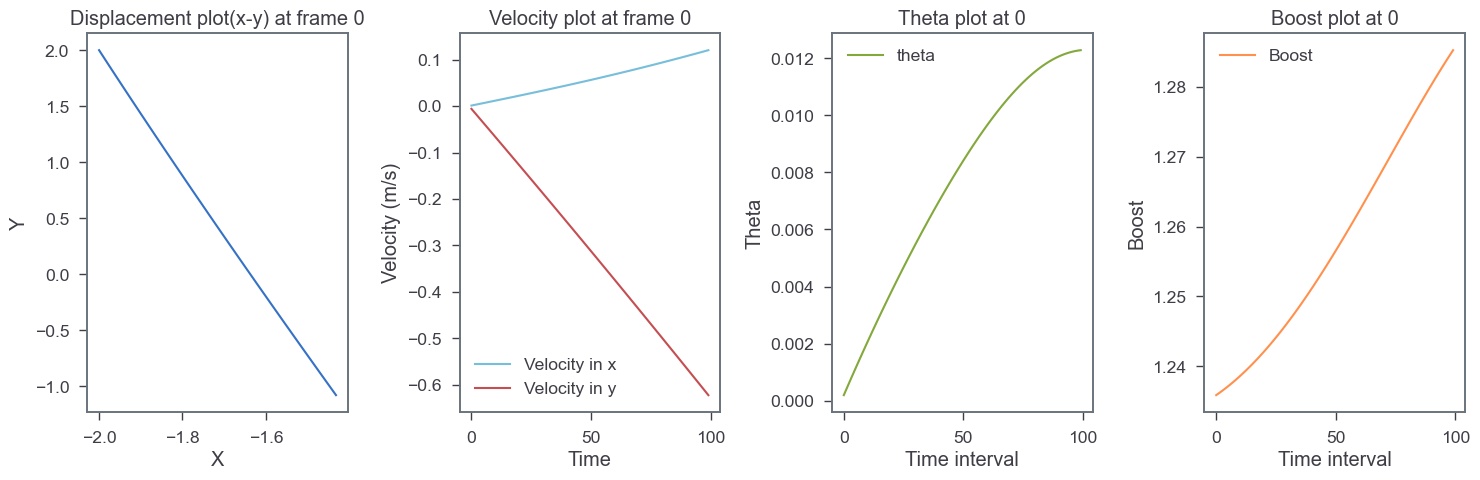

[2] loss: 0.405


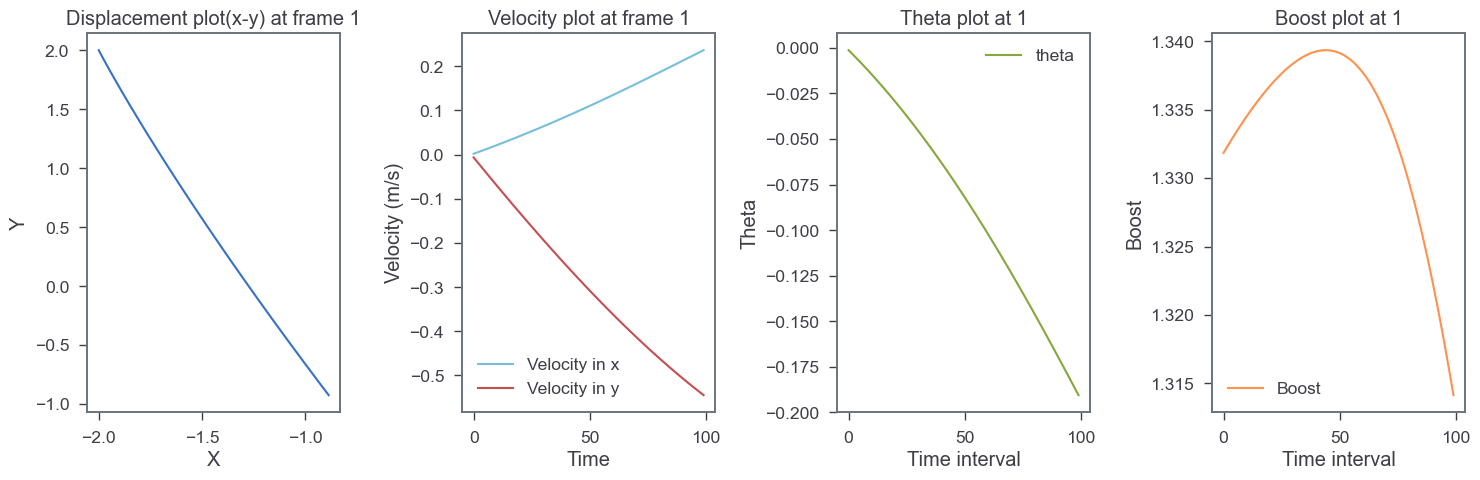

[3] loss: 0.271


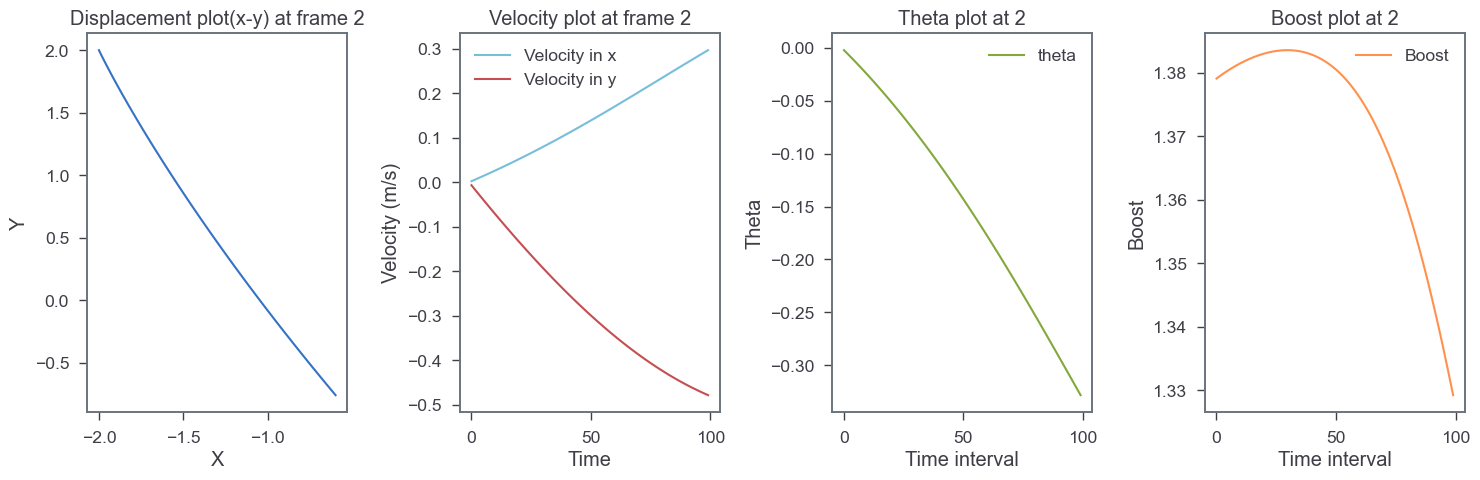

[4] loss: 0.213


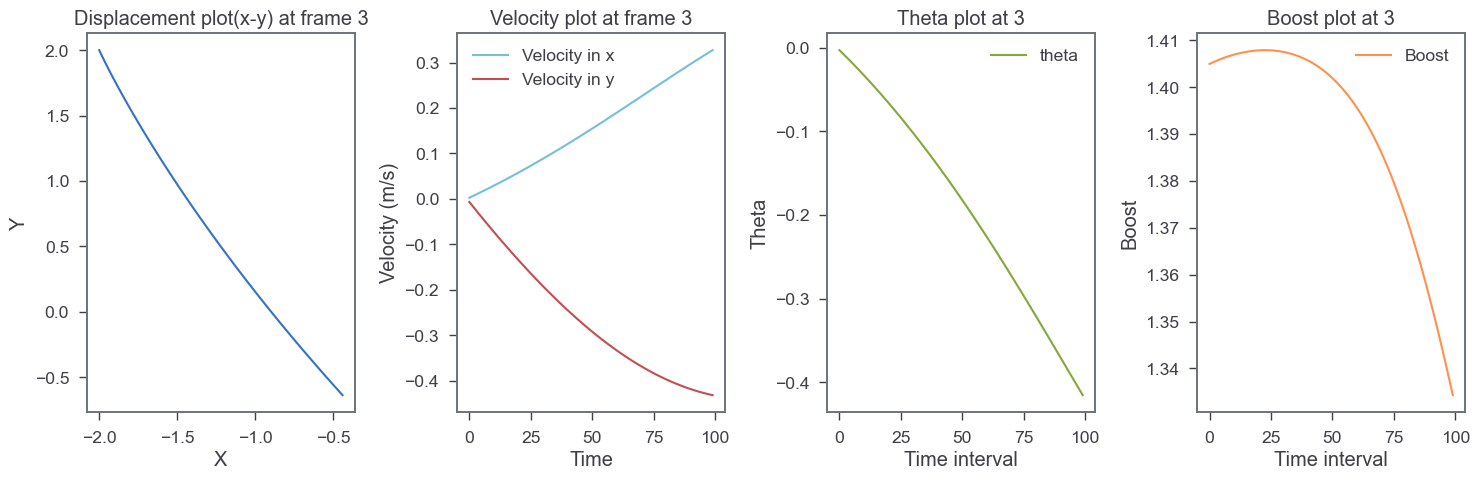

[5] loss: 0.185


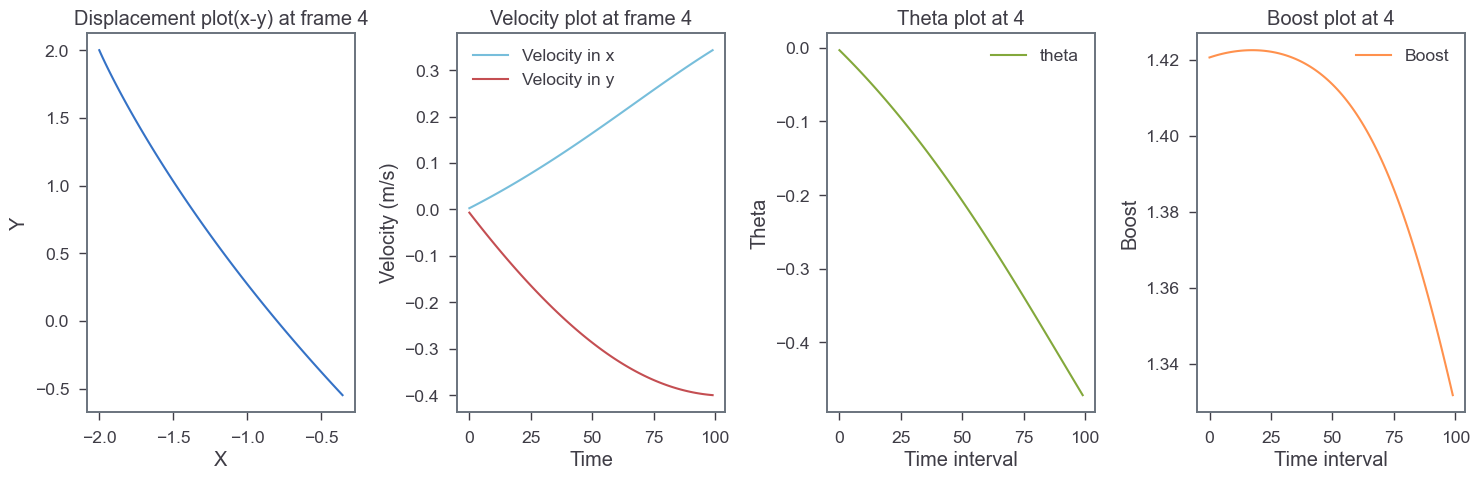

[6] loss: 0.168


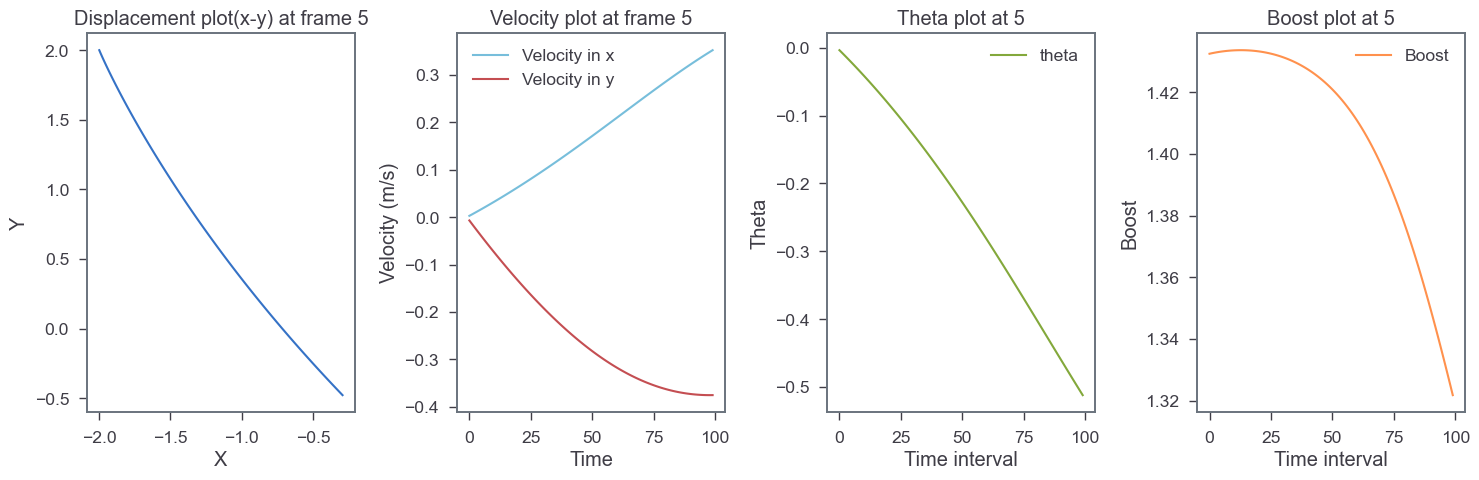

[7] loss: 0.155


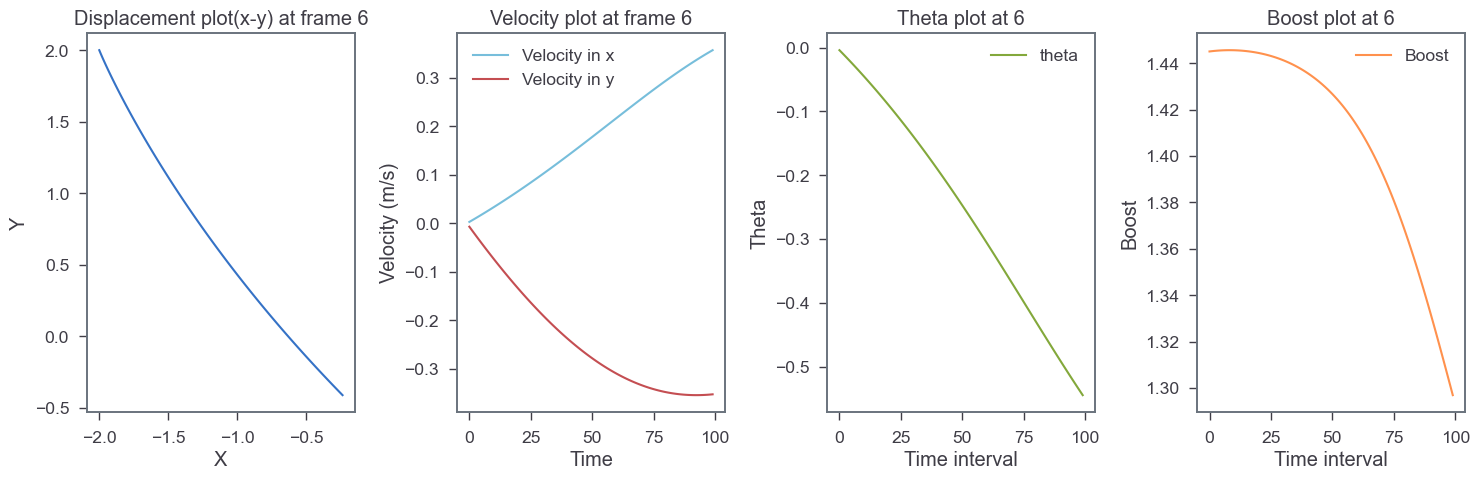

[8] loss: 0.136


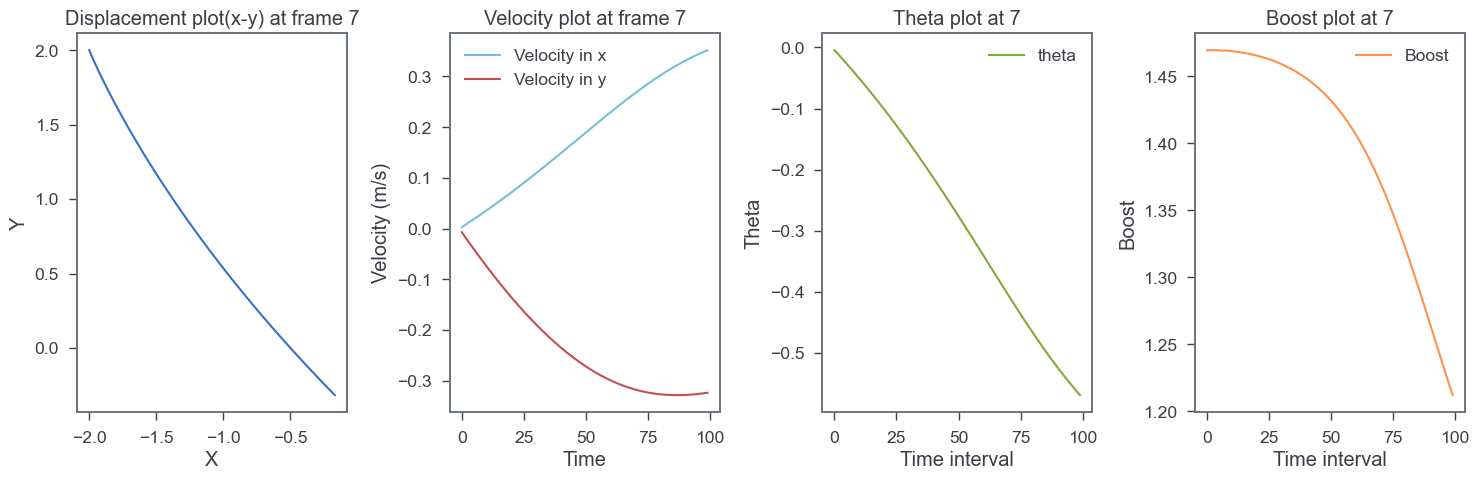

[9] loss: 0.069


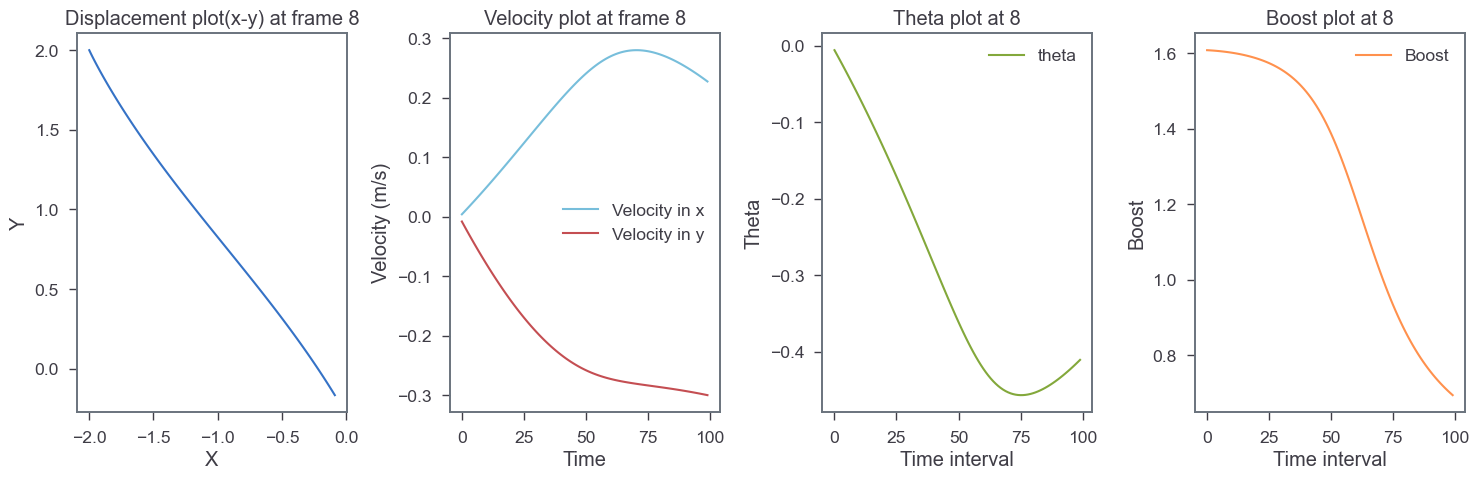

[10] loss: 0.055


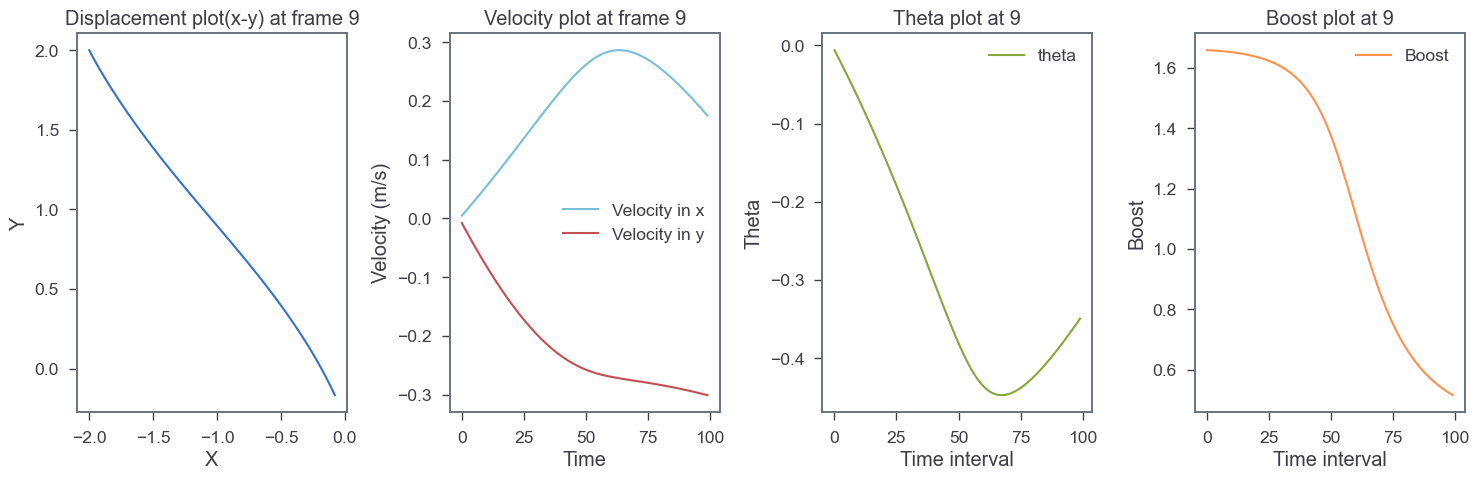

[11] loss: 0.049


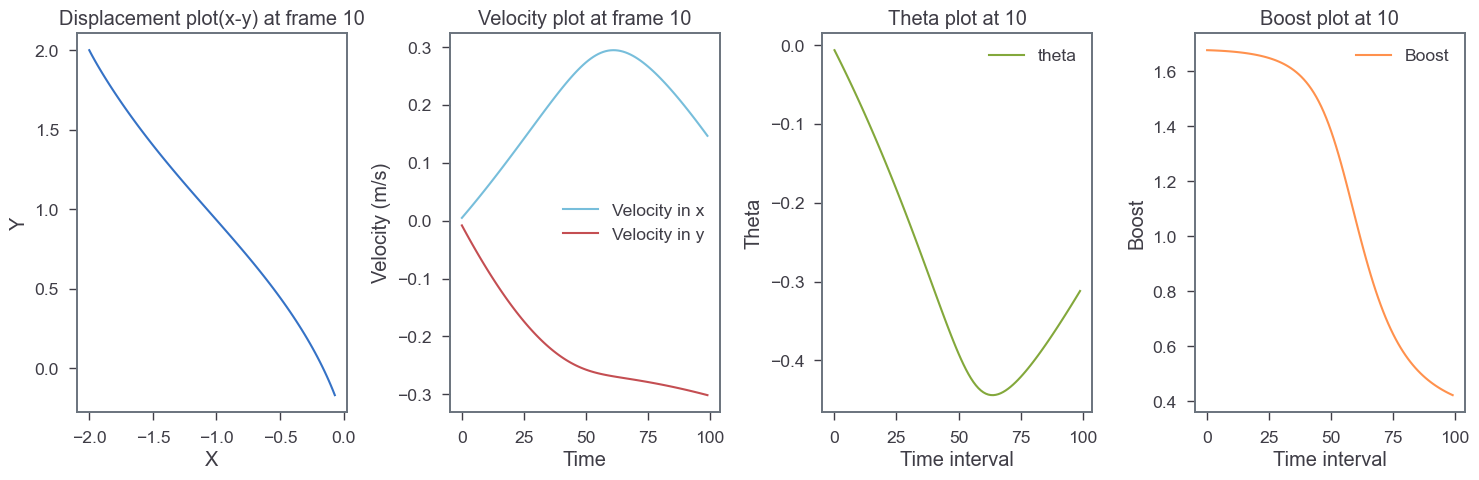

[12] loss: 0.043


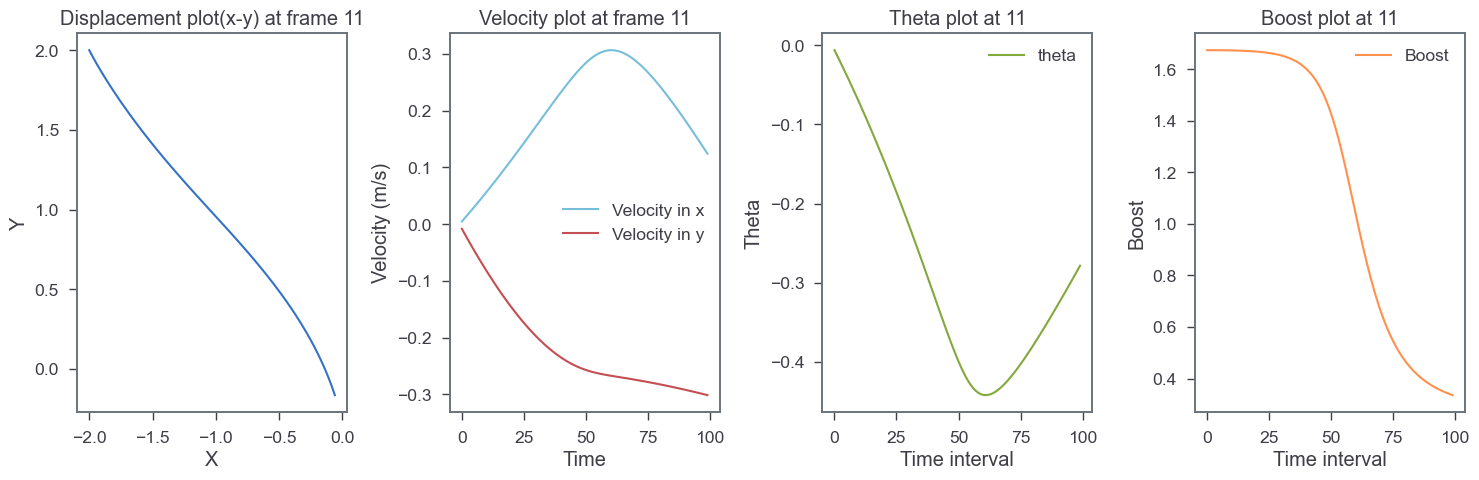

[13] loss: 0.037


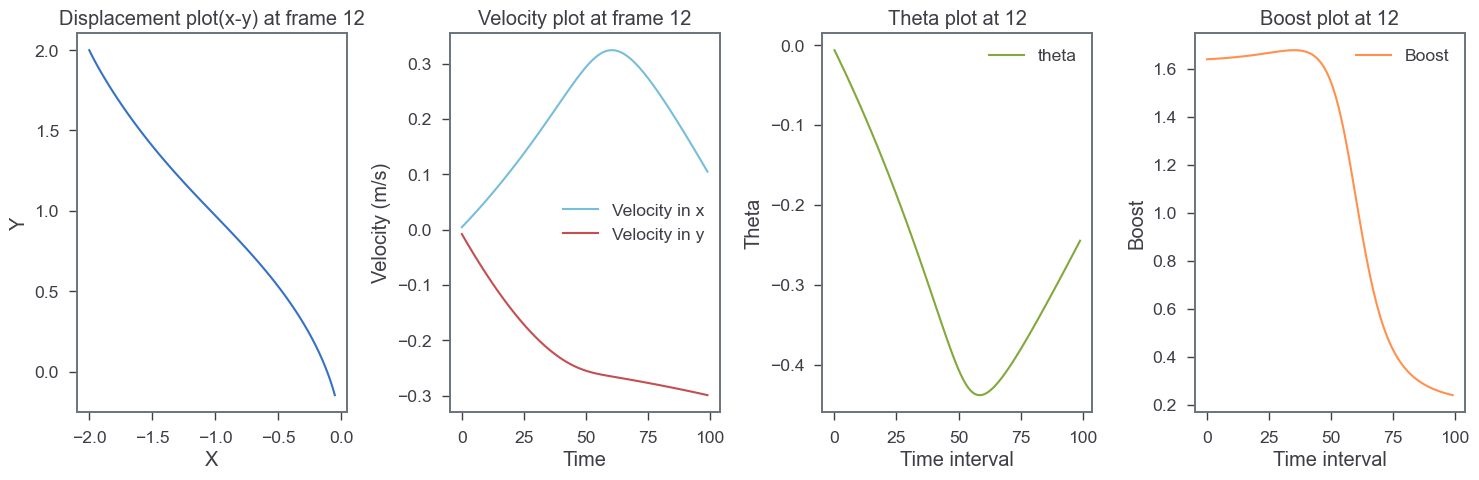

[14] loss: 0.032


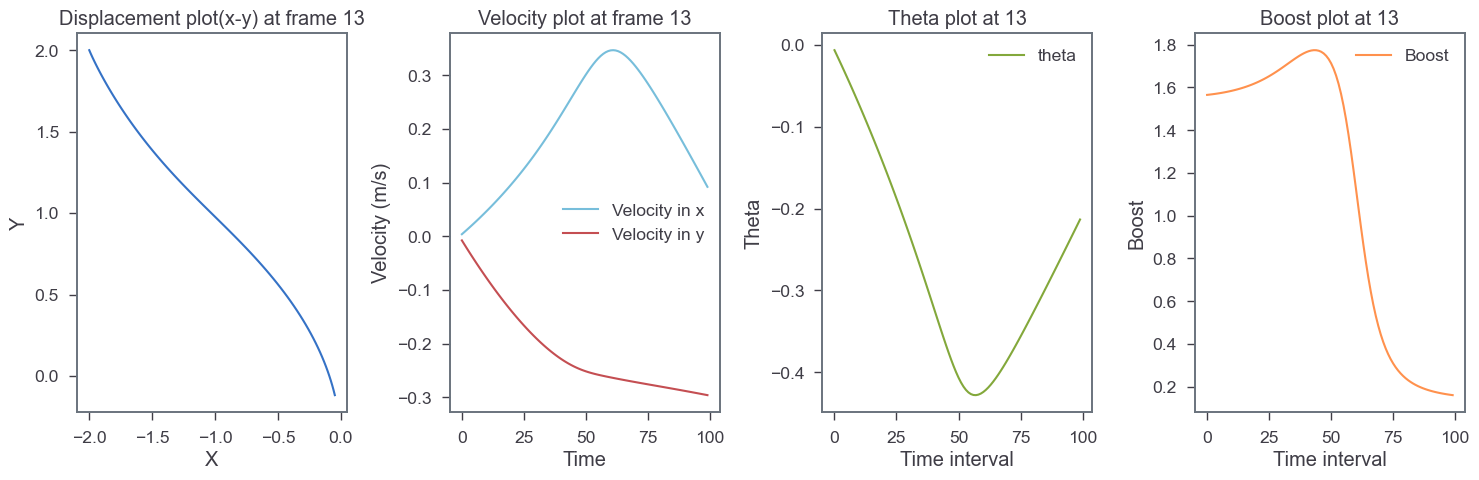

[15] loss: 0.029


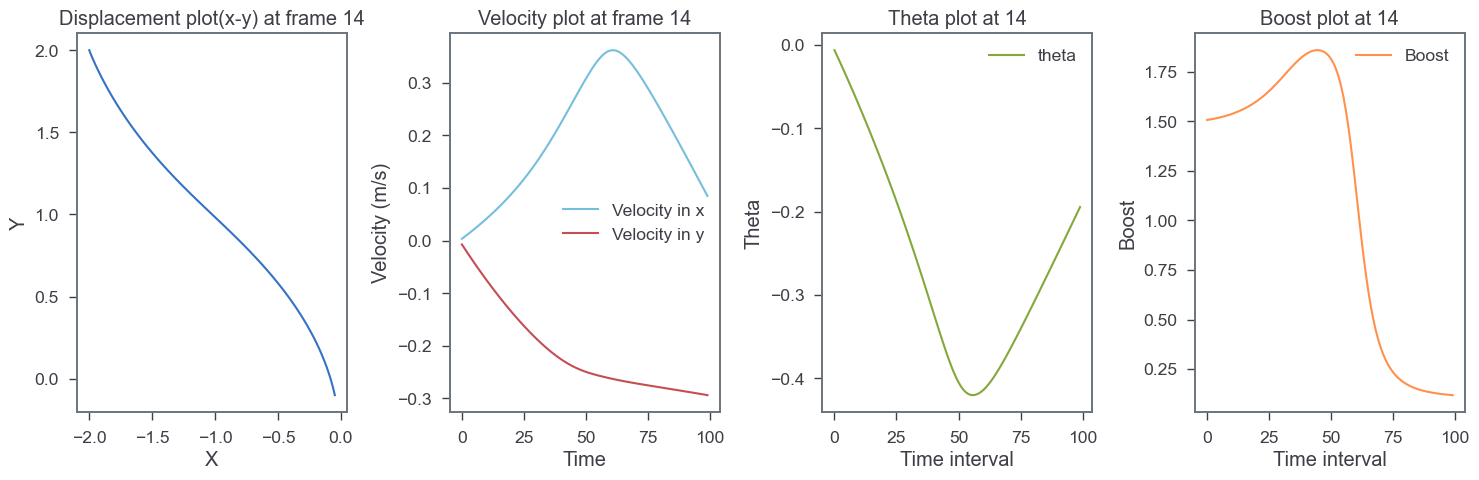

[16] loss: 0.027


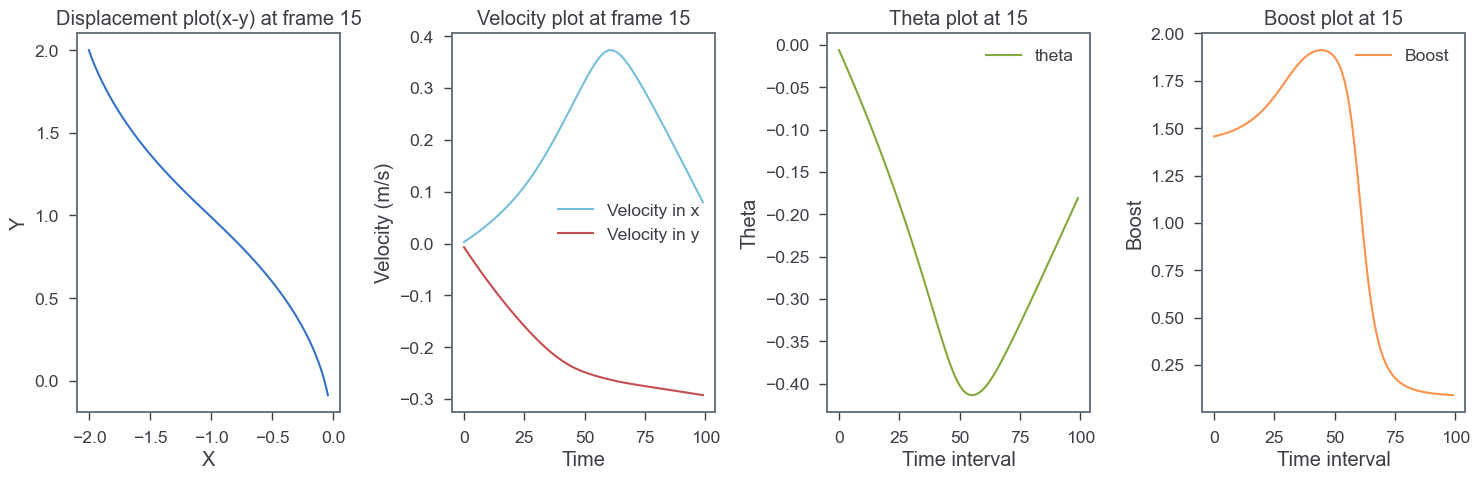

[17] loss: 0.025


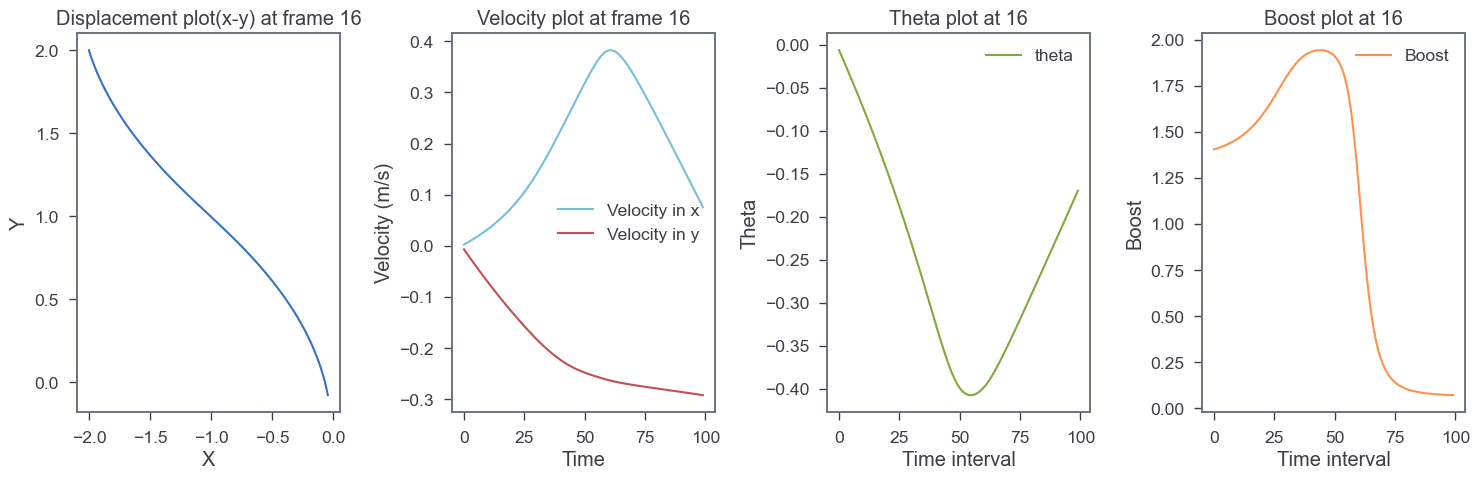

[18] loss: 0.024


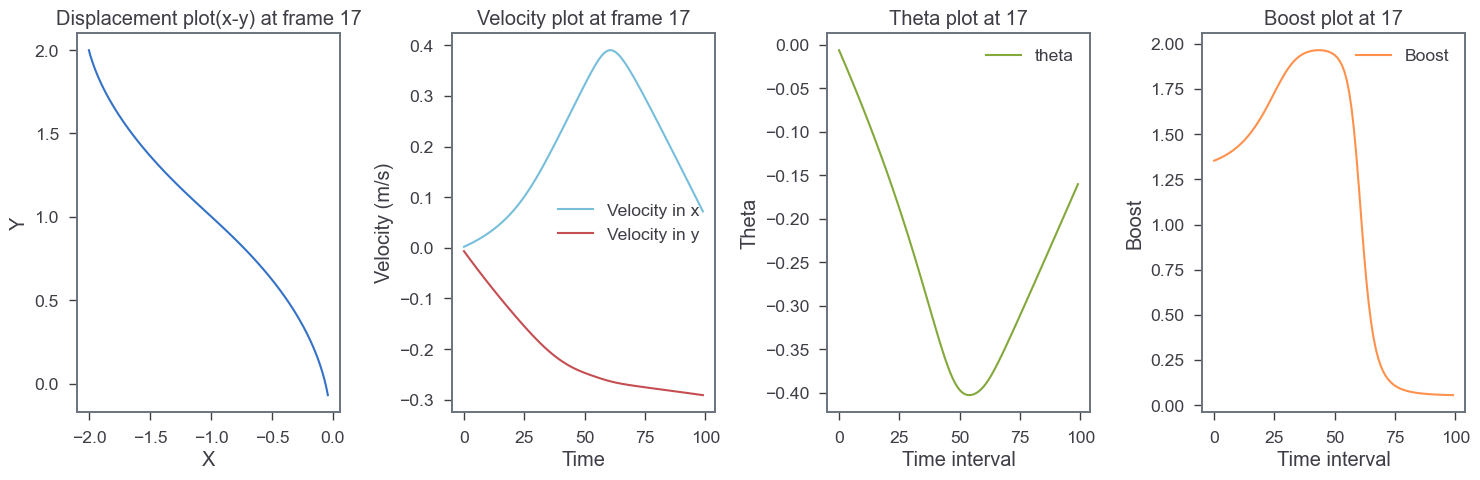

[19] loss: 0.024


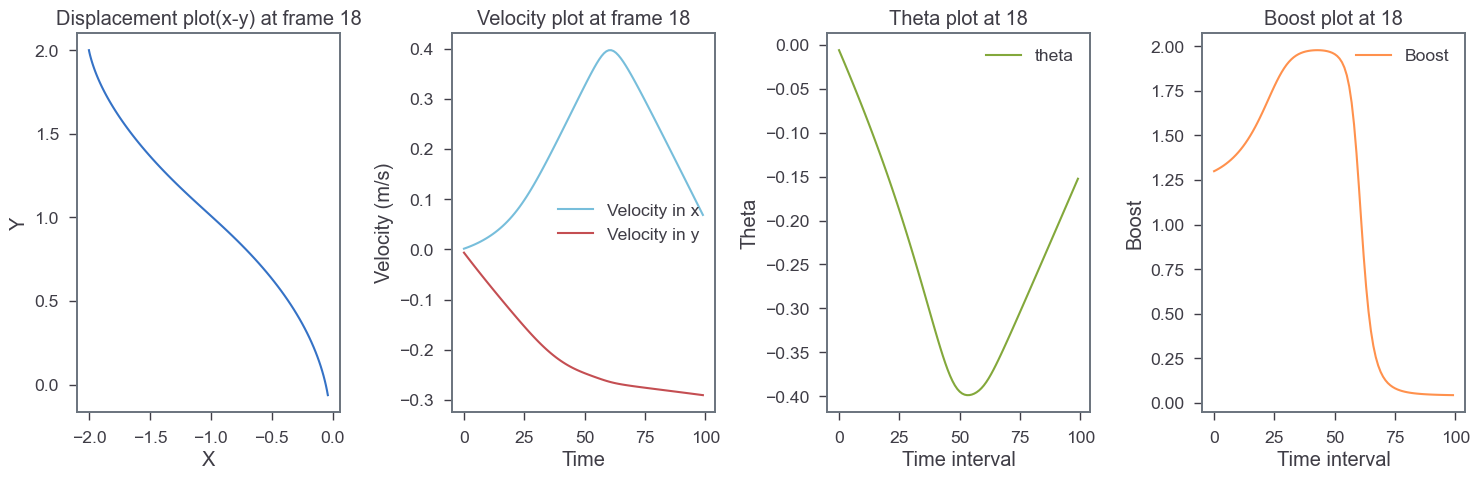

[20] loss: 0.023


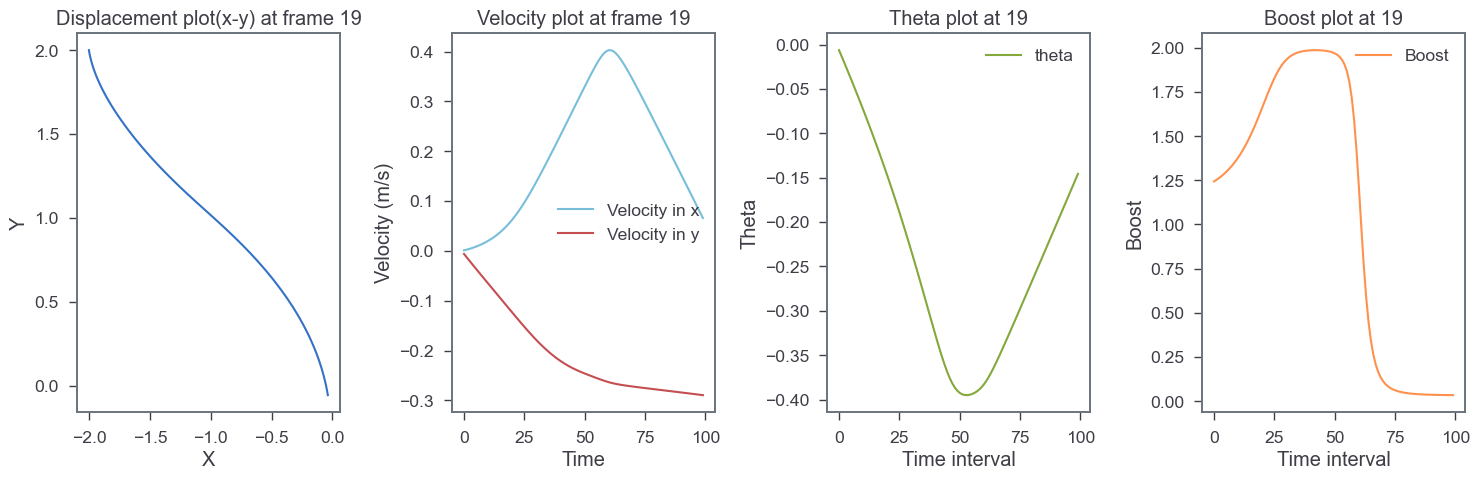

[21] loss: 0.022


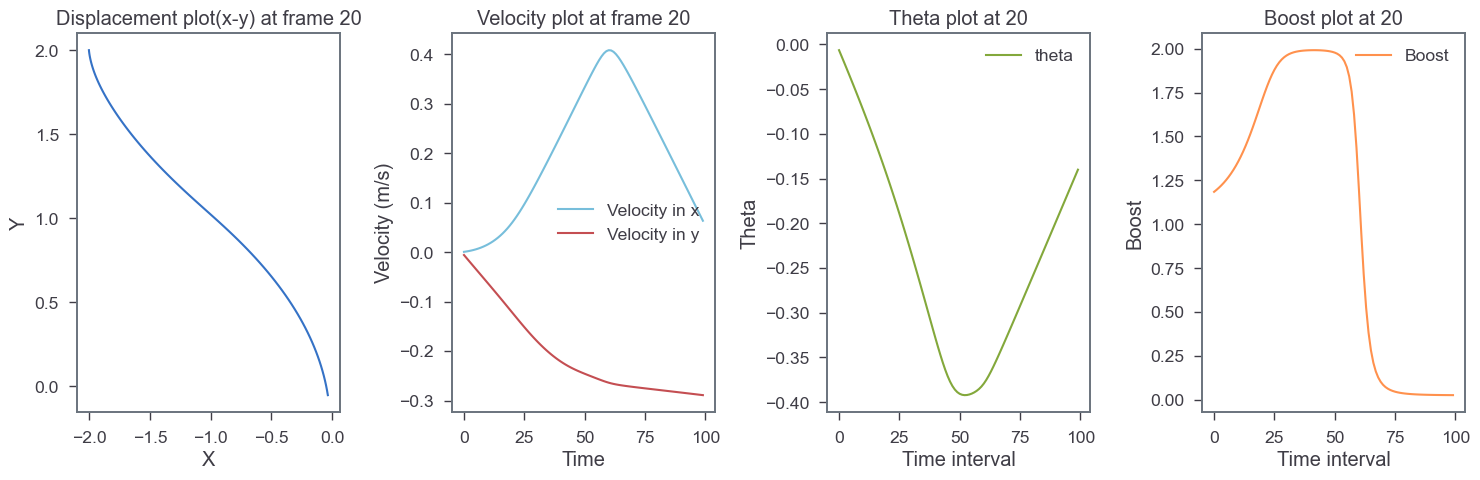

[22] loss: 0.022


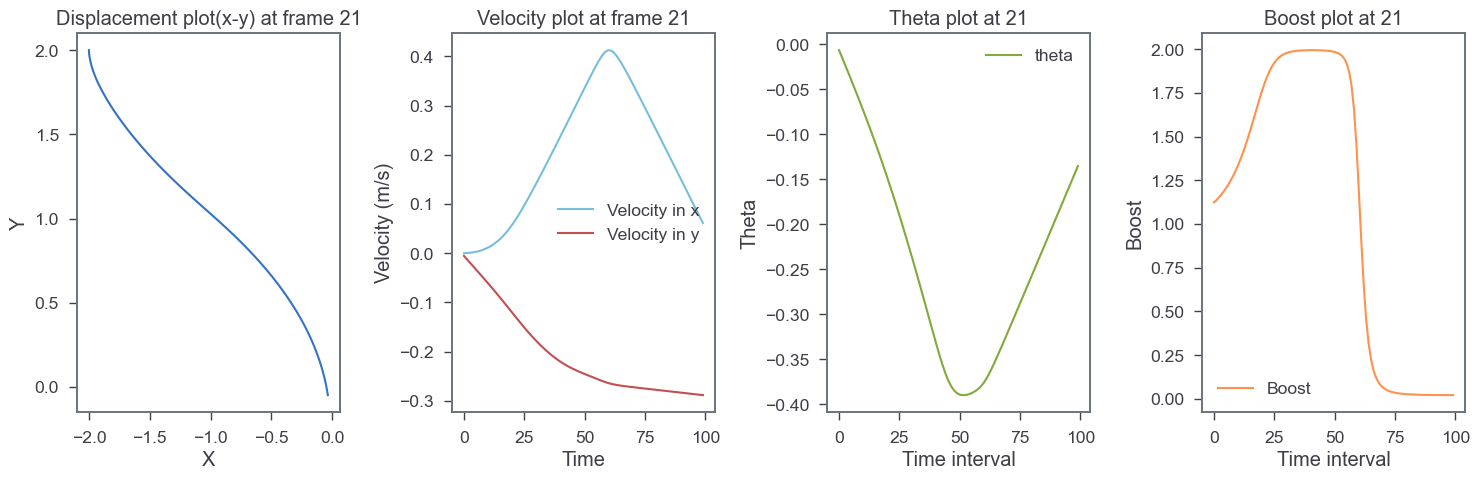

[23] loss: 0.021


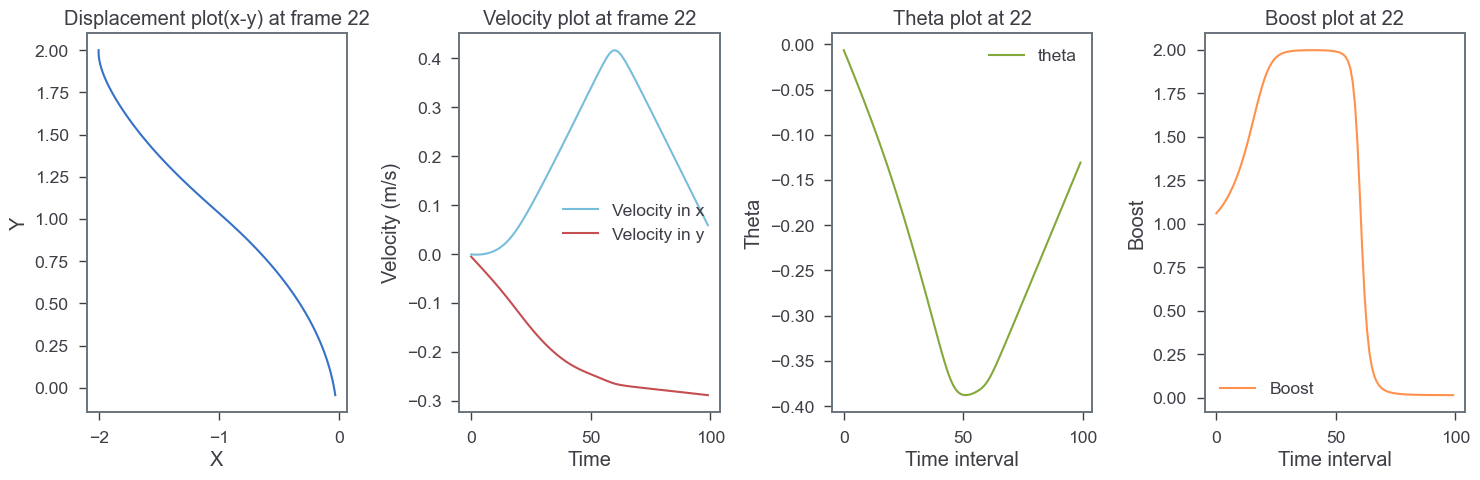

[24] loss: 0.021


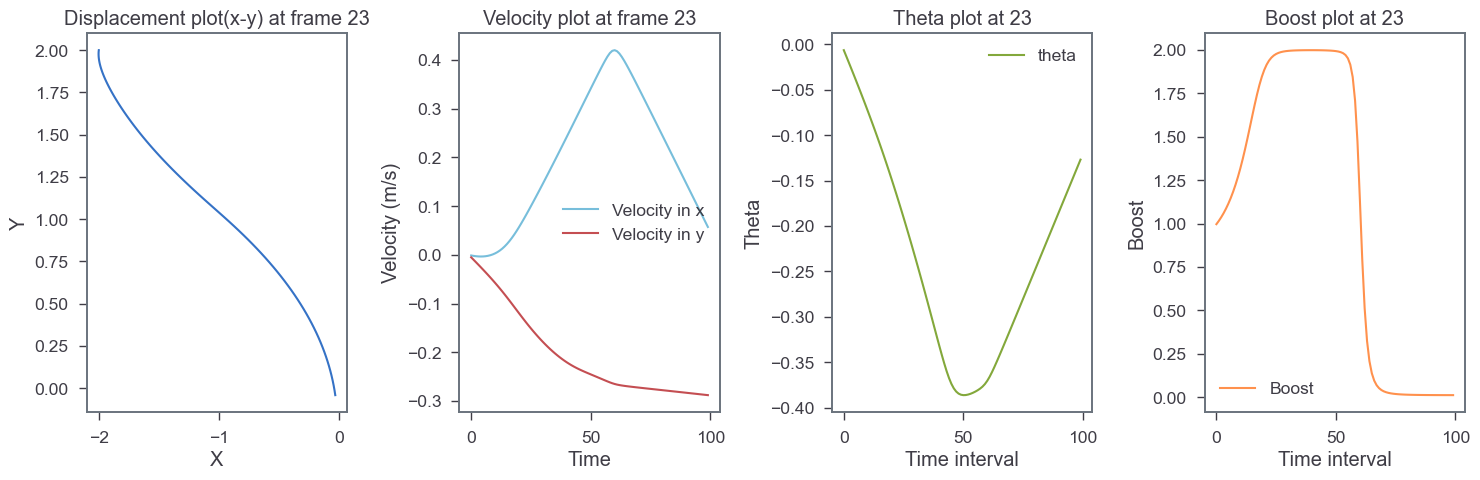

[25] loss: 0.021


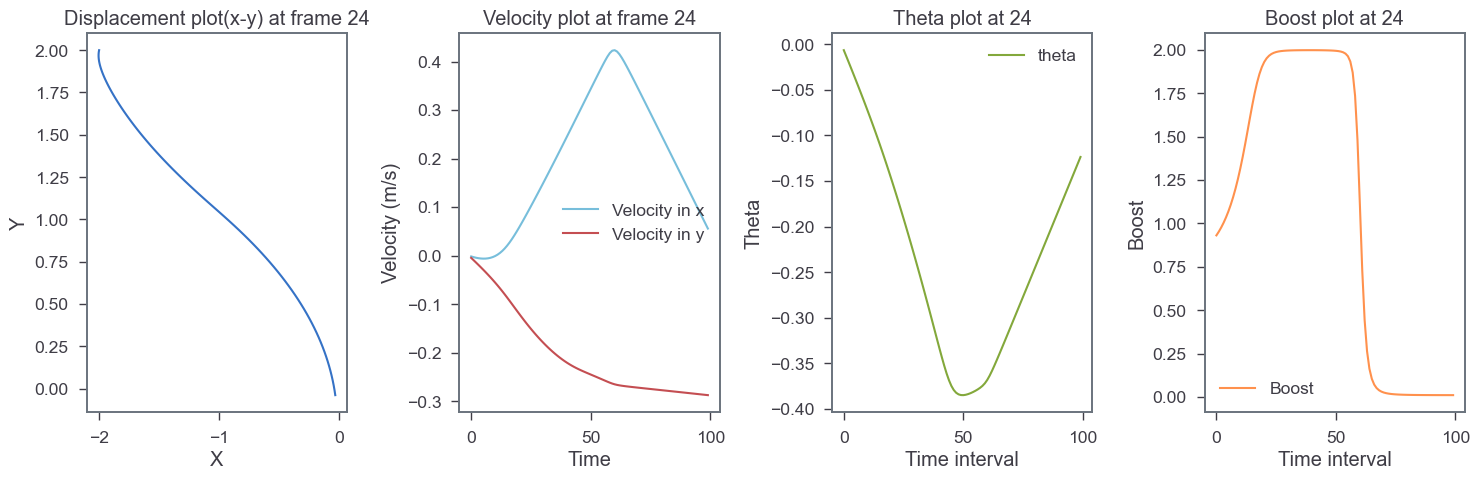

[26] loss: 0.020


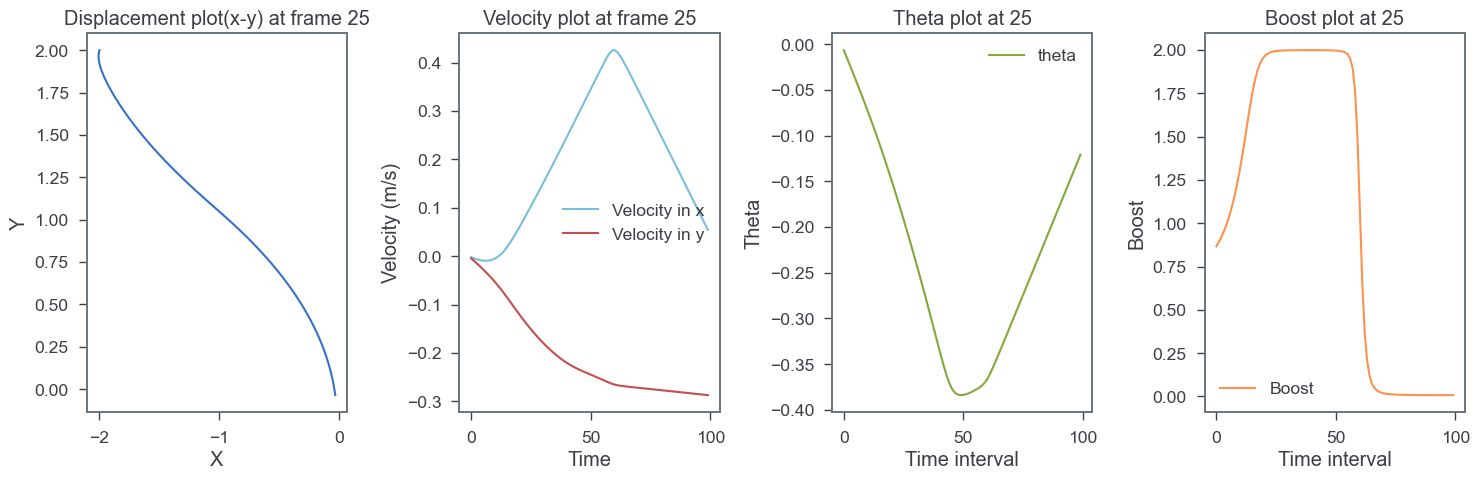

[27] loss: 0.020


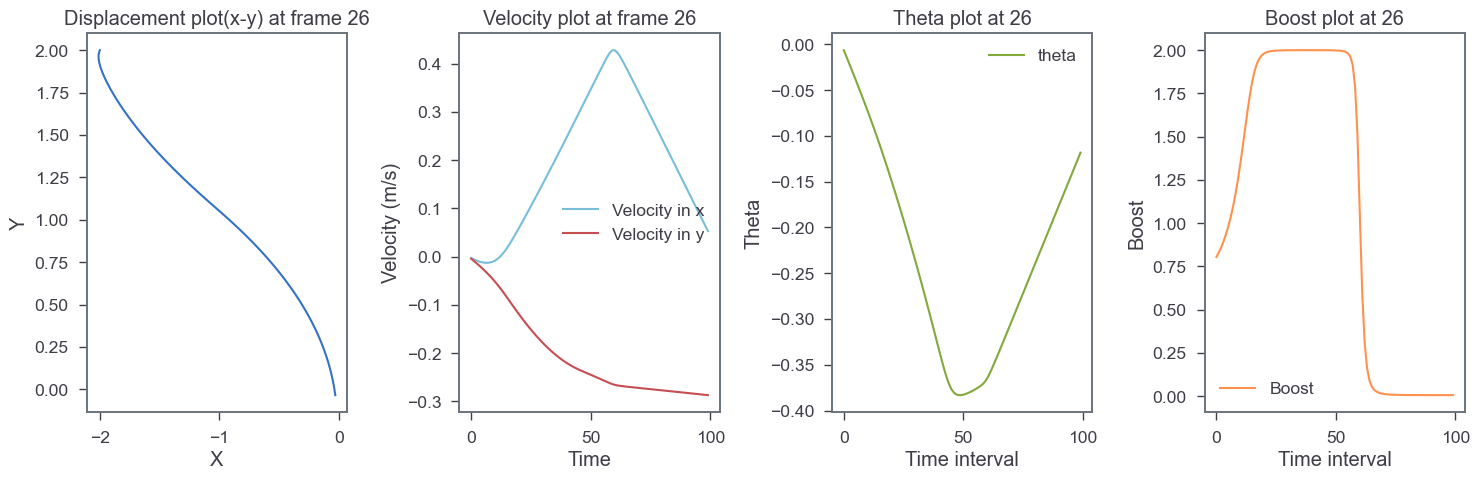

[28] loss: 0.020


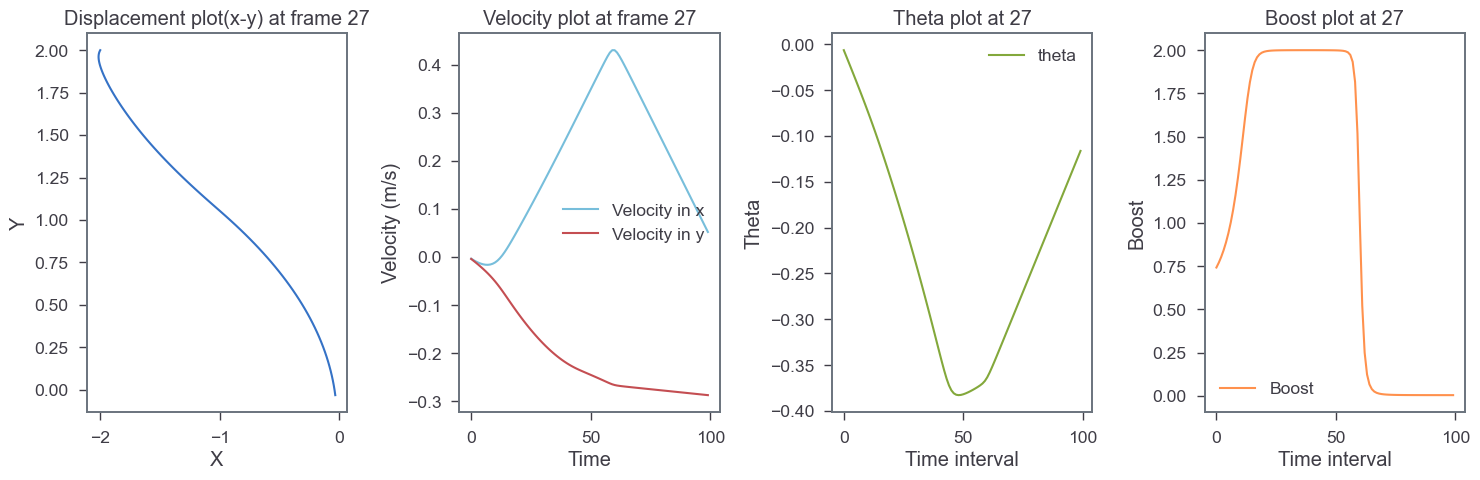

[29] loss: 0.020


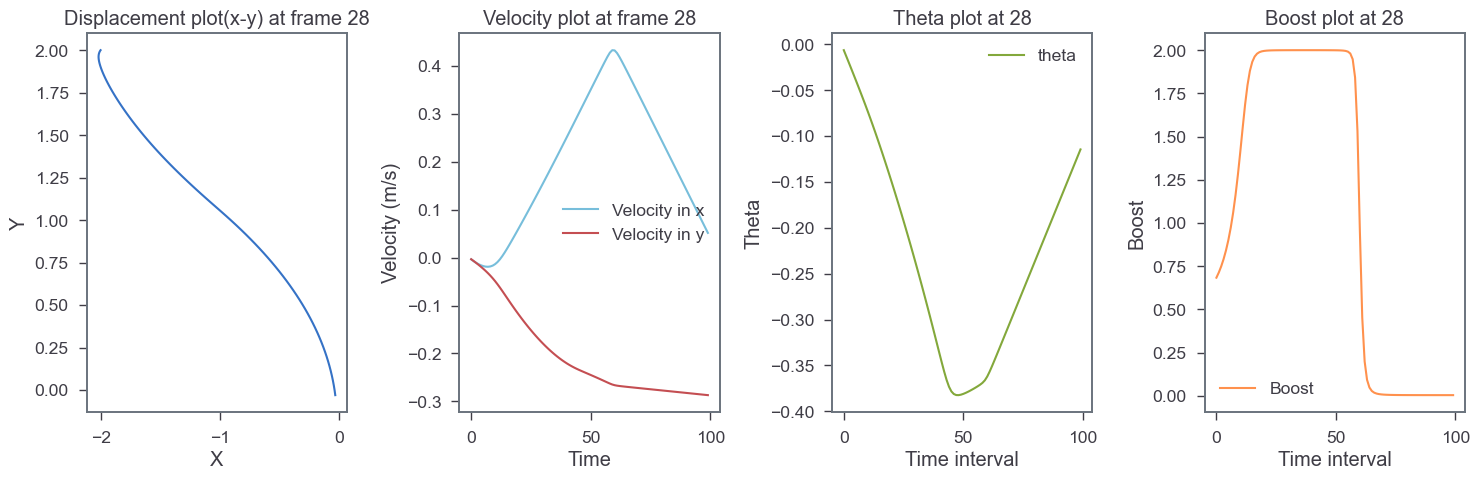

[30] loss: 0.020


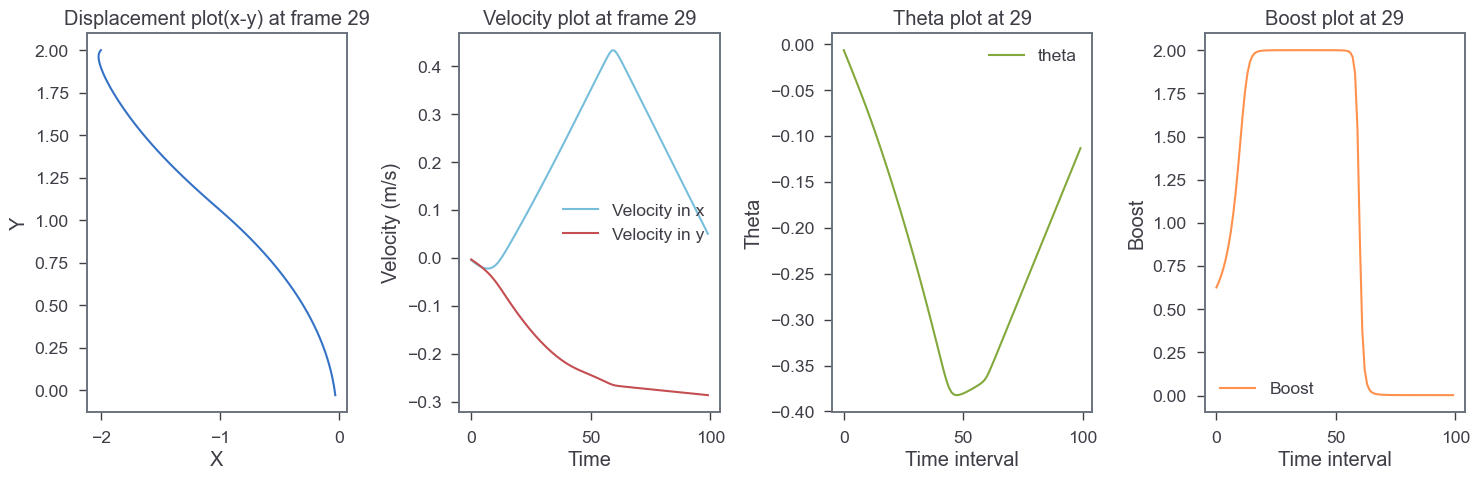

[31] loss: 0.020


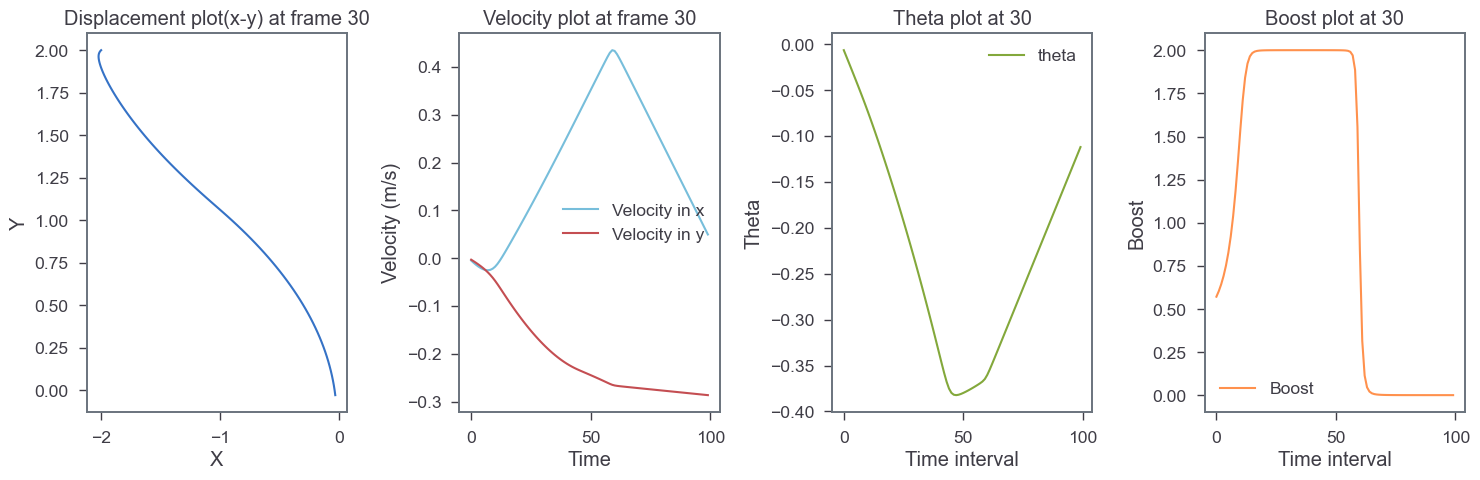

[32] loss: 0.020


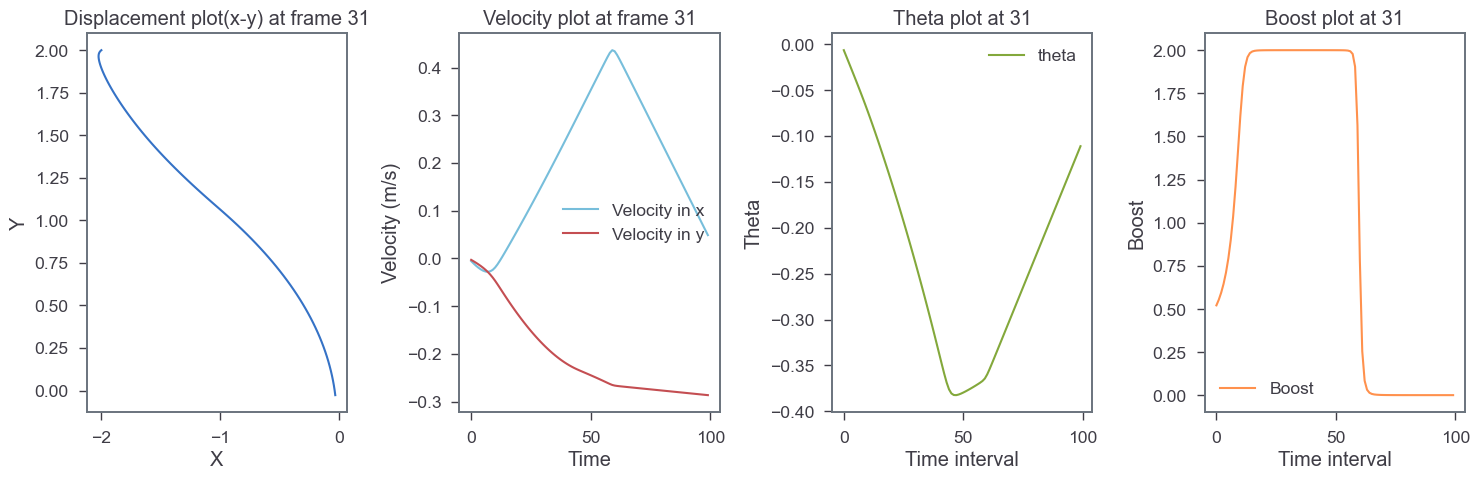

[33] loss: 0.020


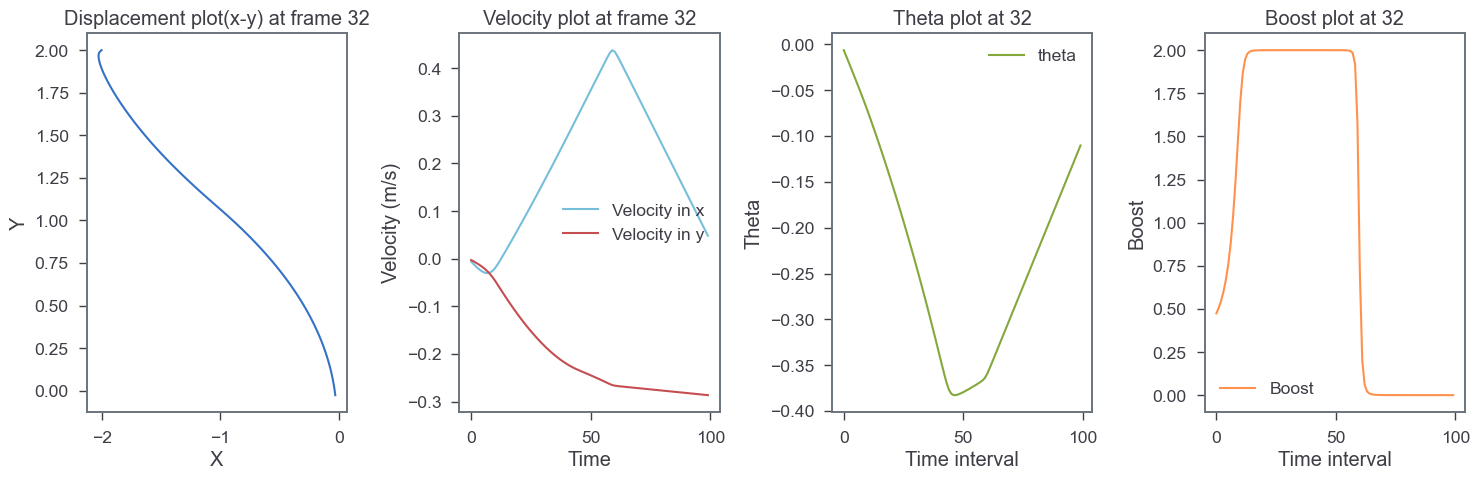

[34] loss: 0.020


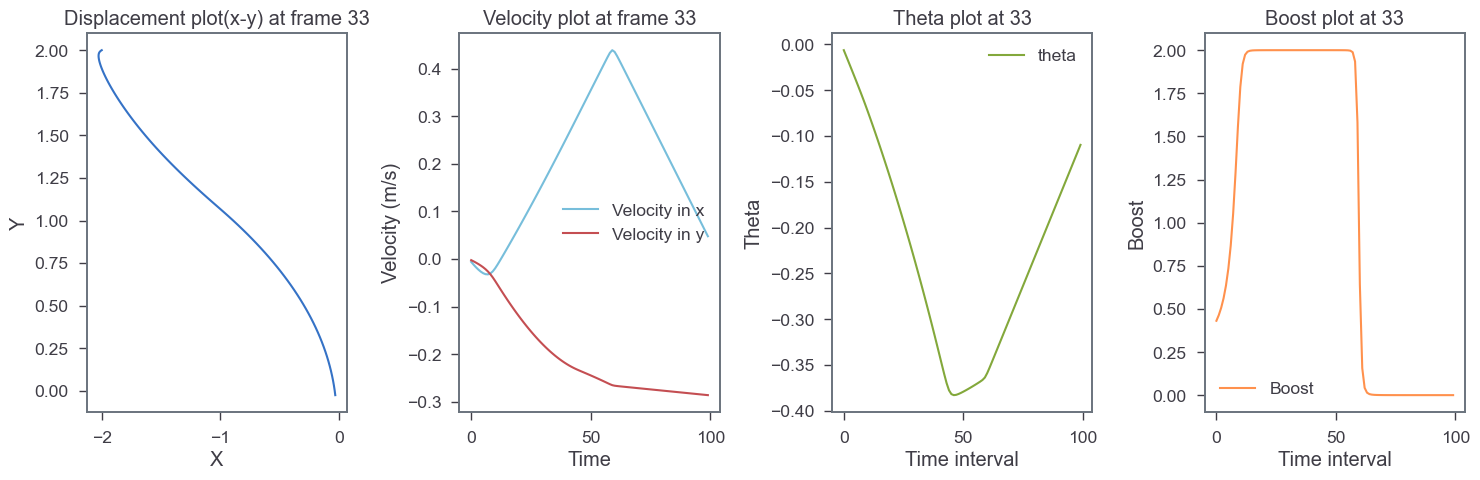

[35] loss: 0.020


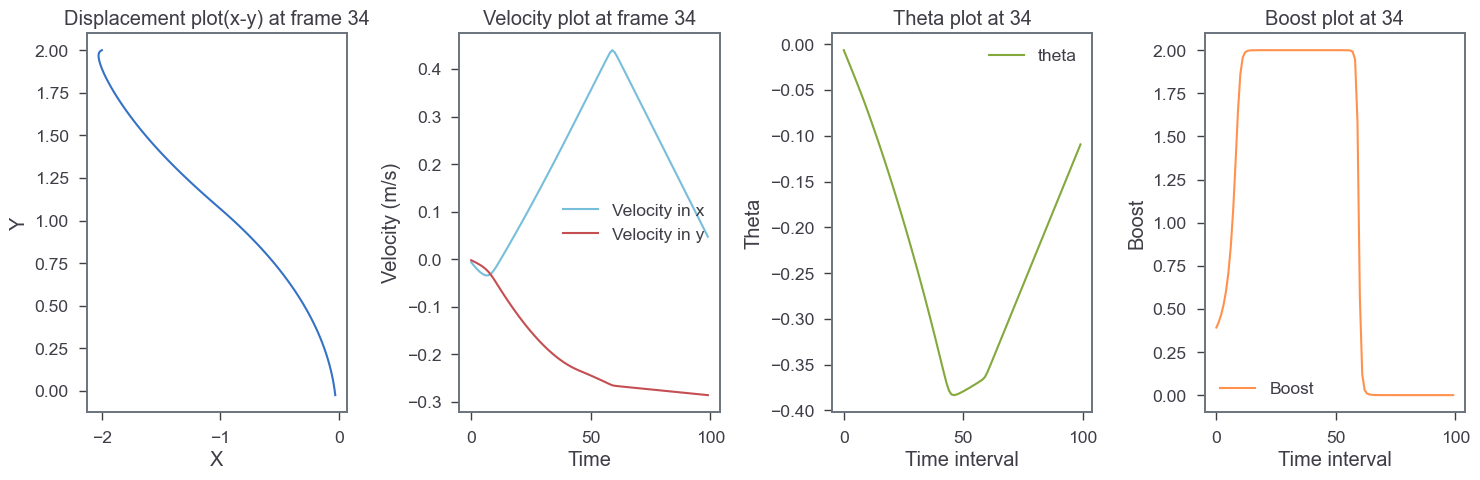

[36] loss: 0.019


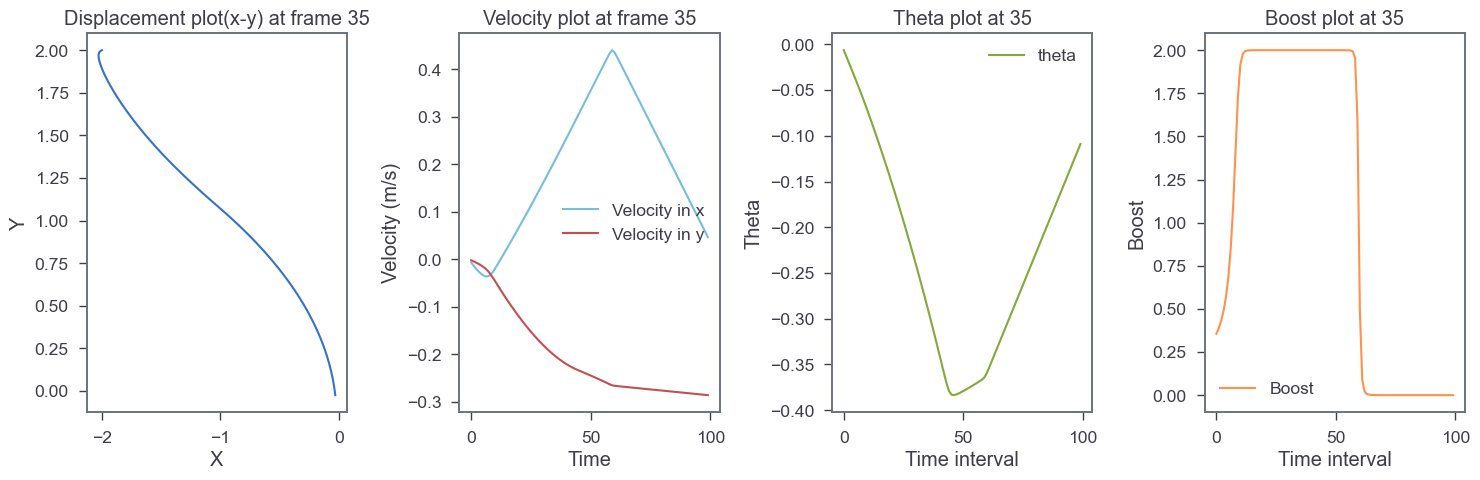

[37] loss: 0.019


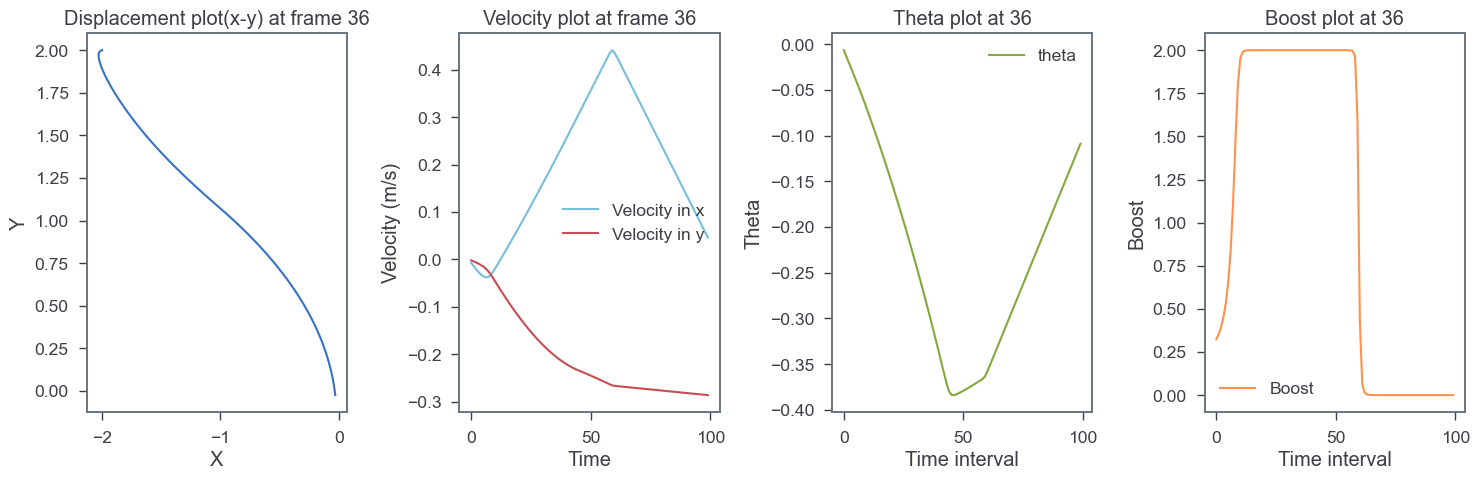

[38] loss: 0.019


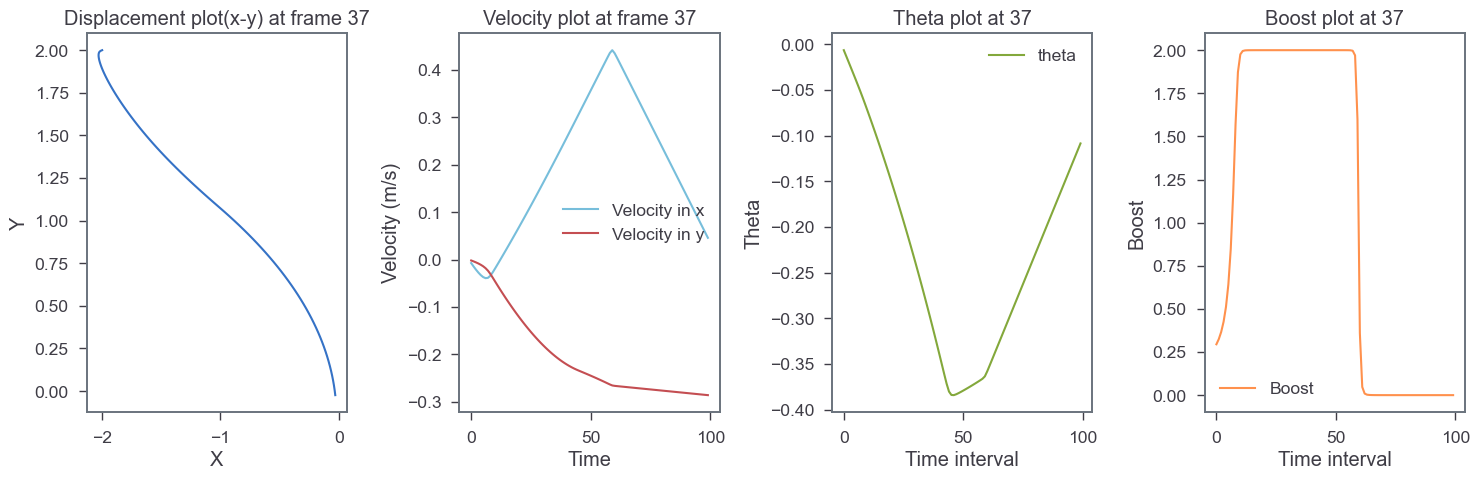

[39] loss: 0.019


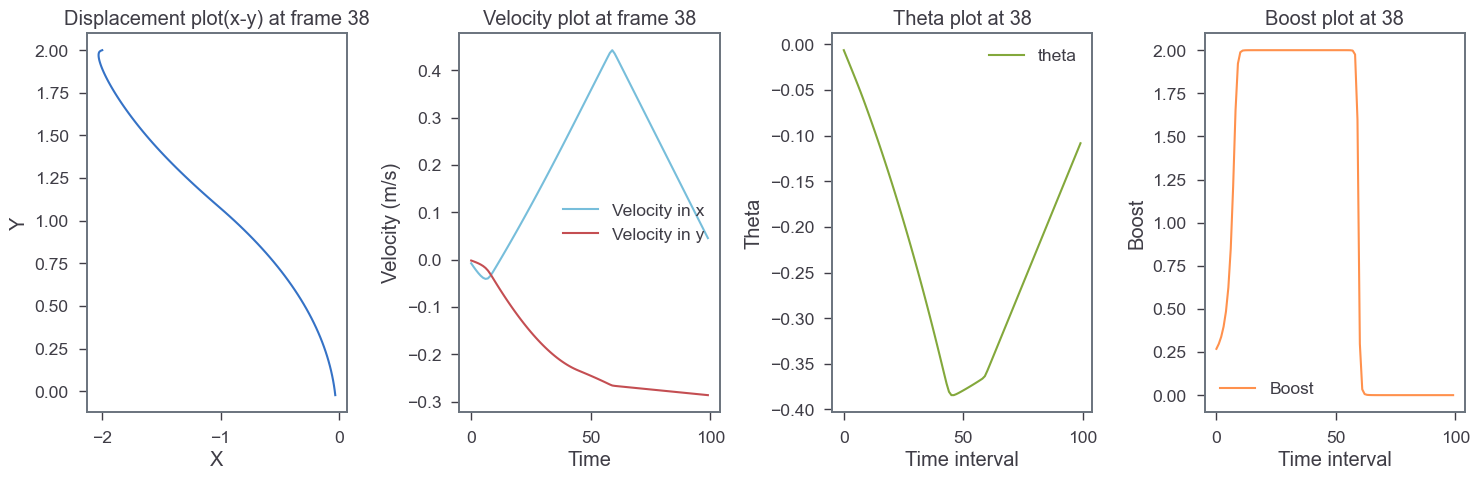

[40] loss: 0.019


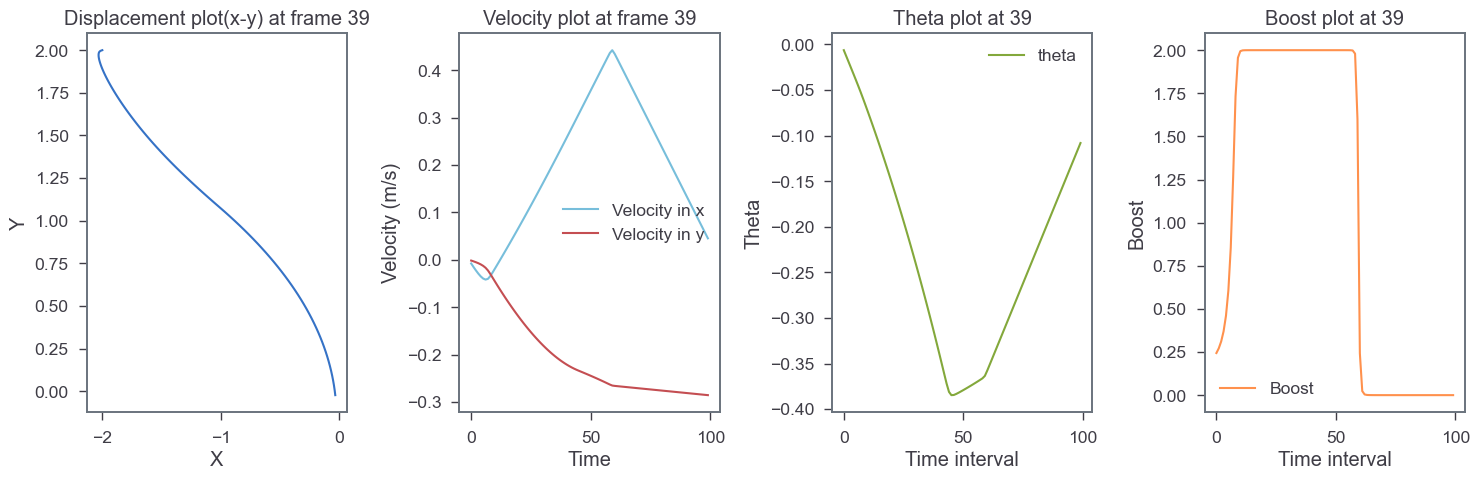

[41] loss: 0.019


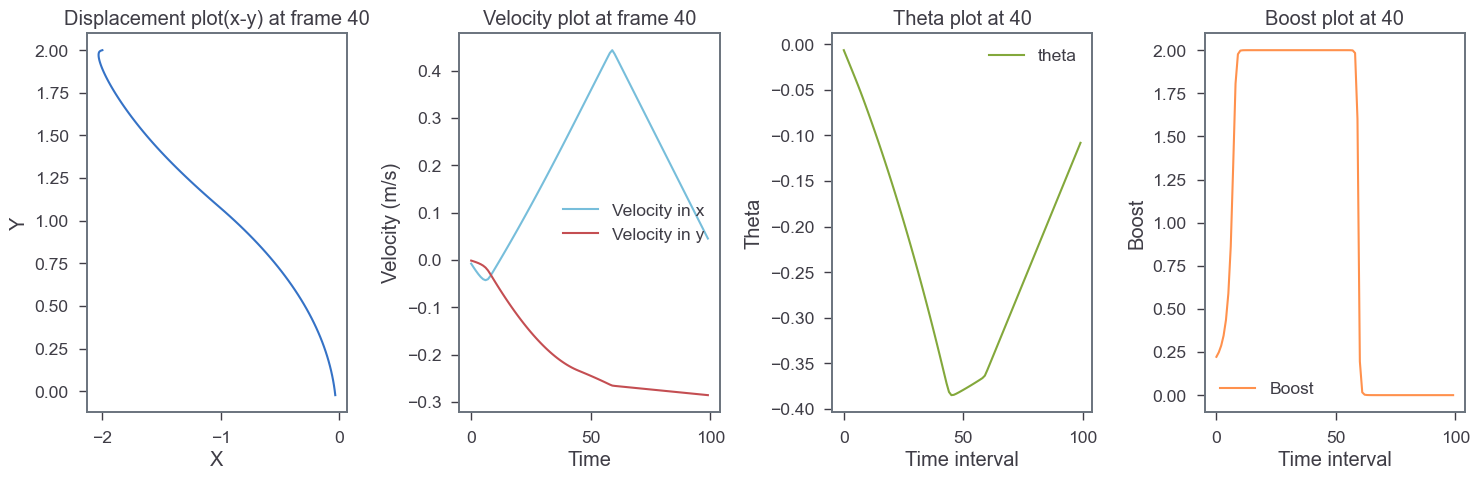

[42] loss: 0.019


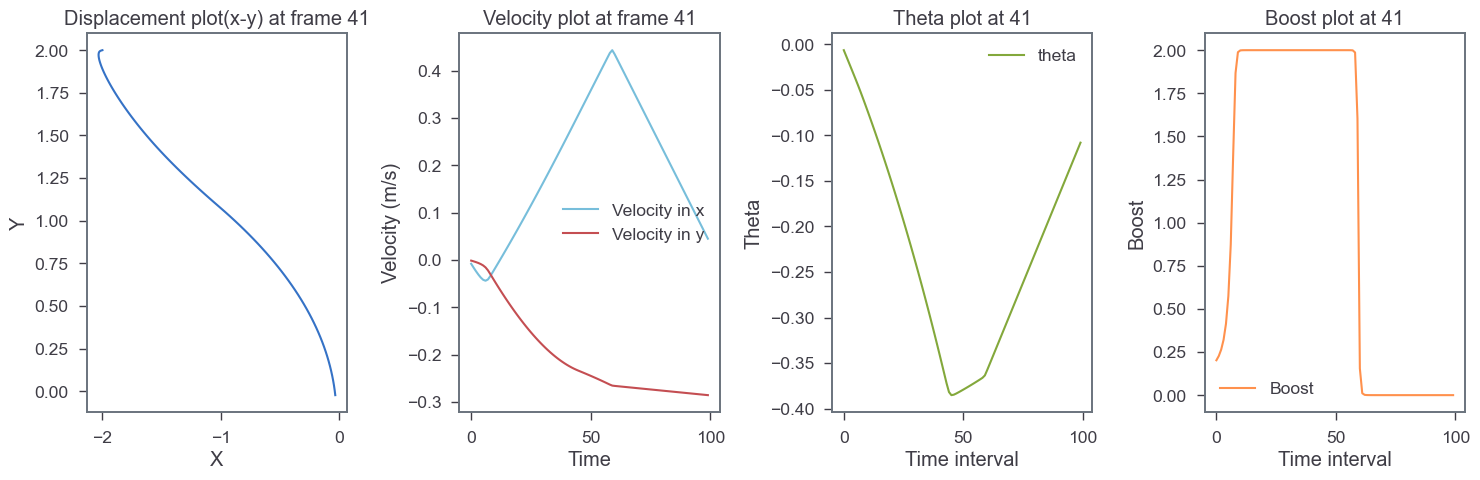

[43] loss: 0.019


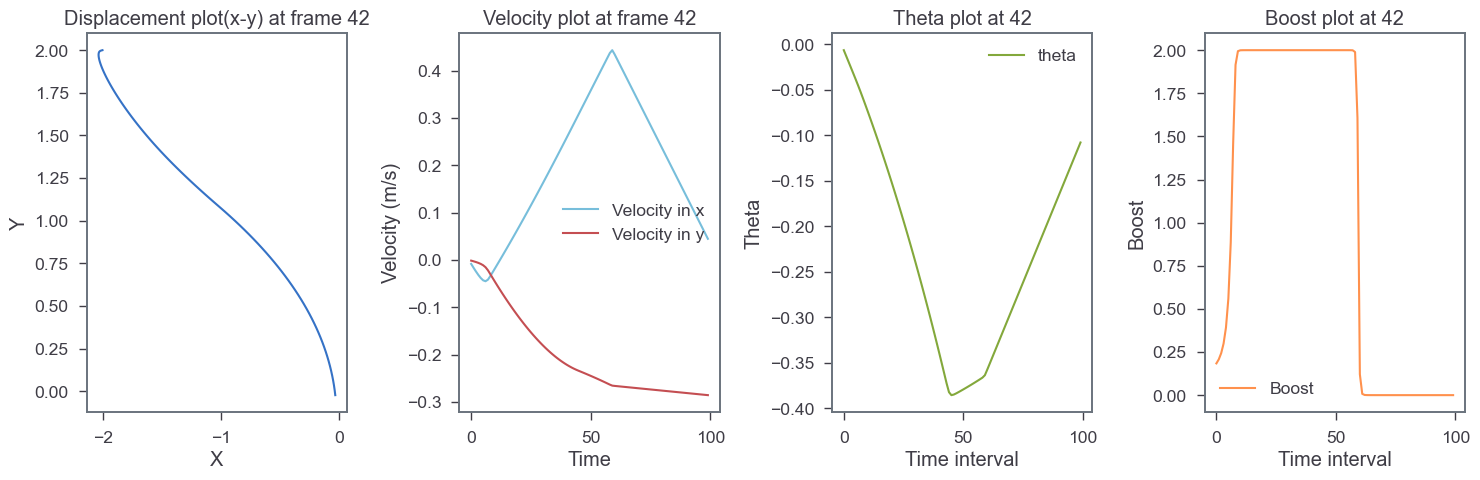

[44] loss: 0.019


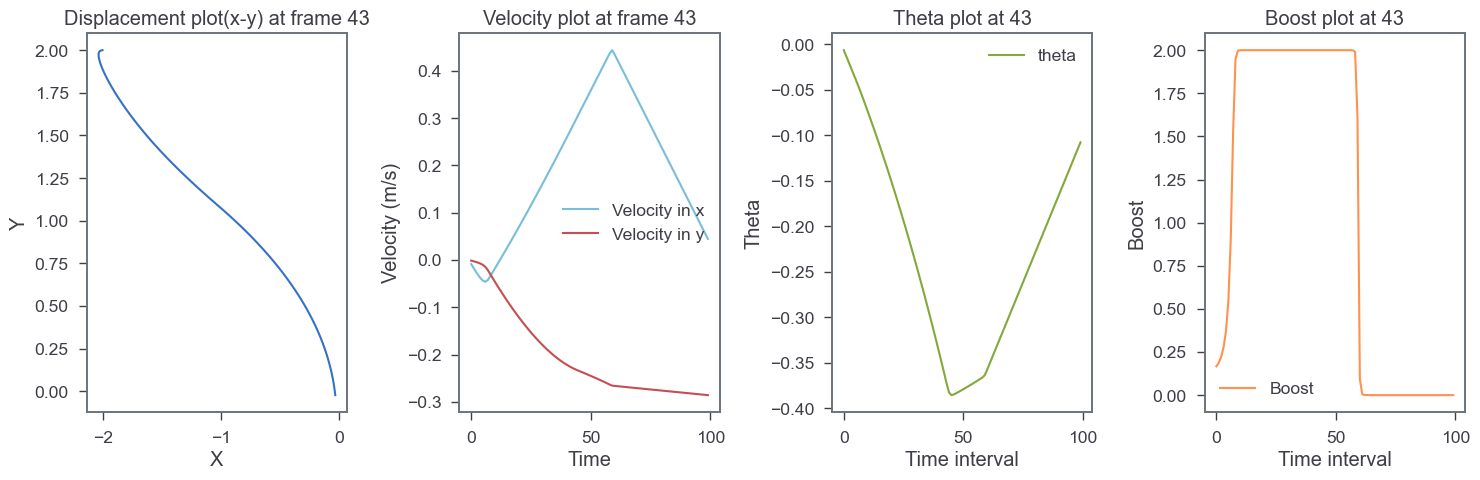

[45] loss: 0.019


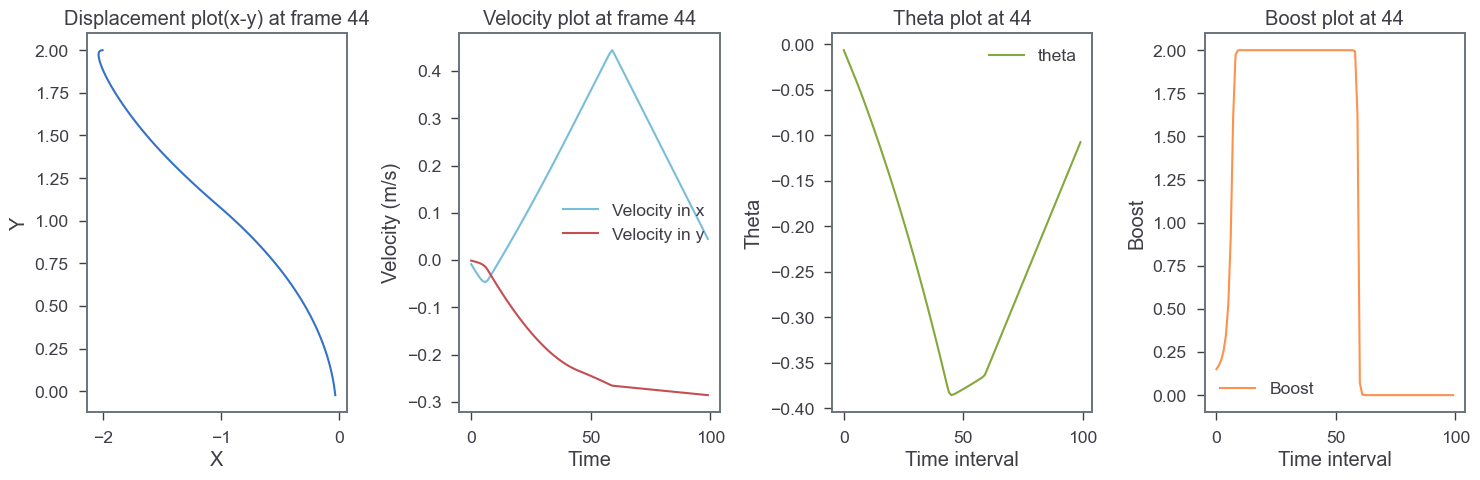

[46] loss: 0.019


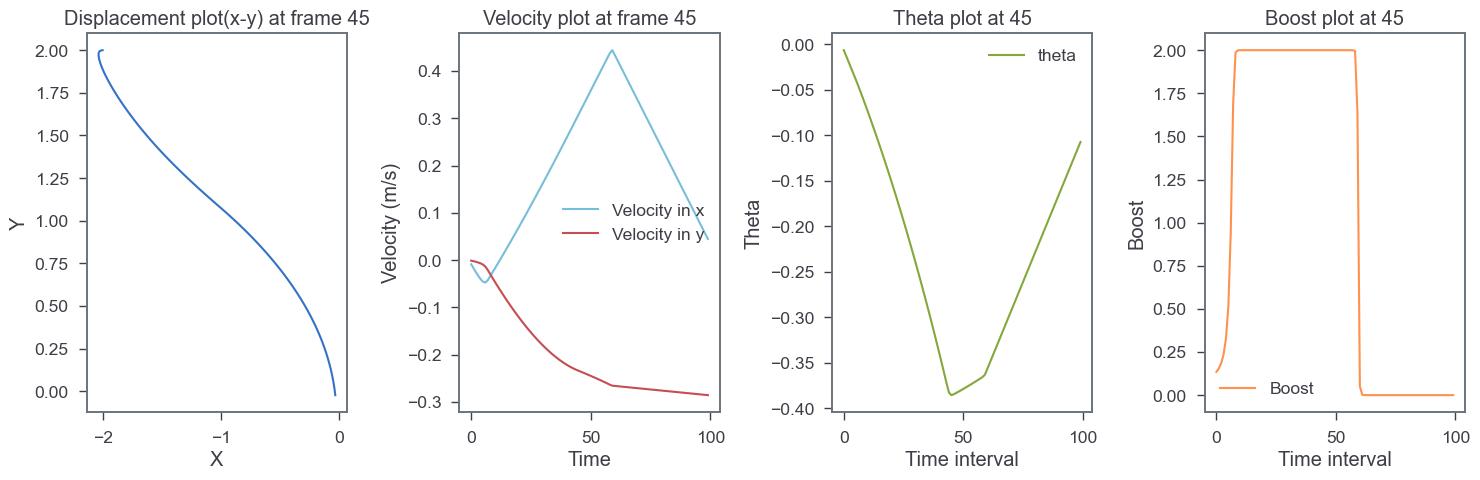

[47] loss: 0.019


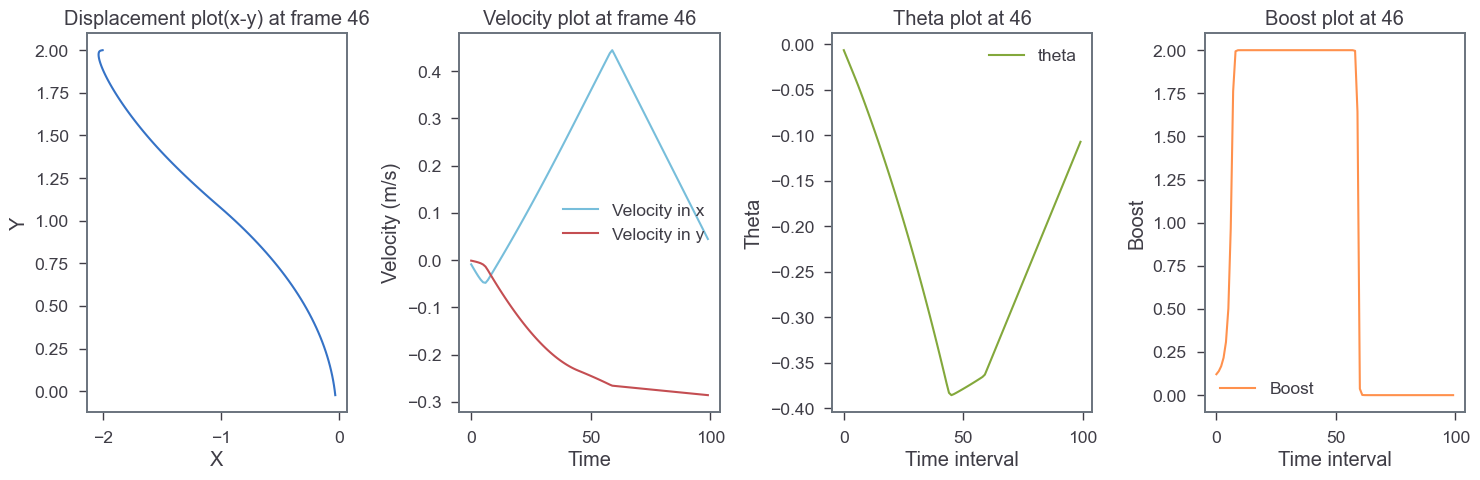

[48] loss: 0.019


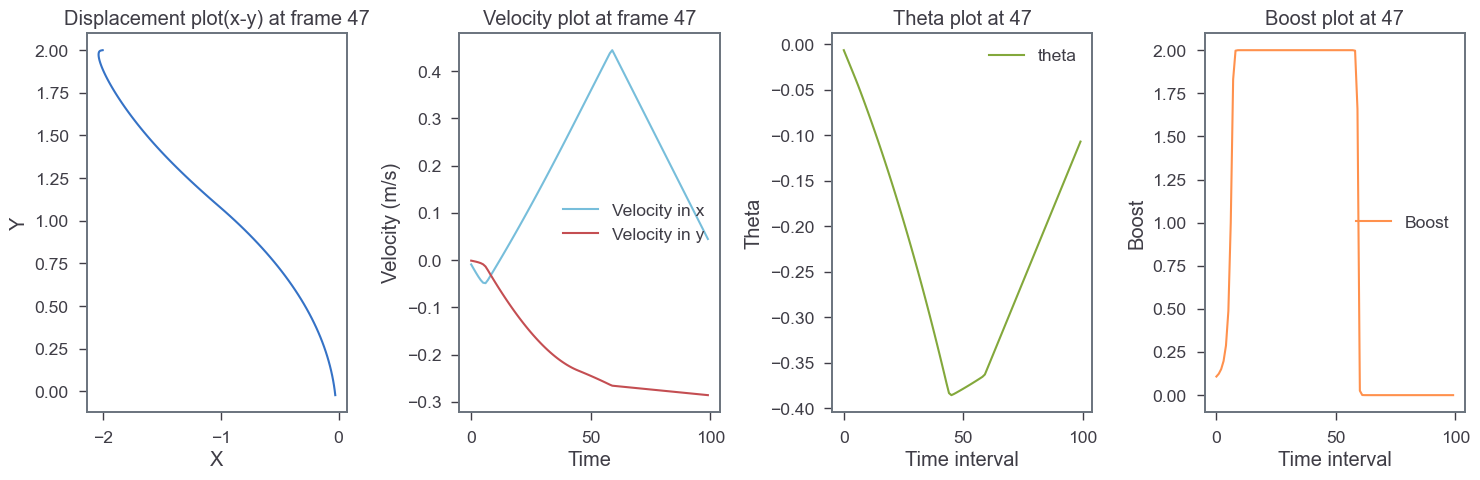

[49] loss: 0.019


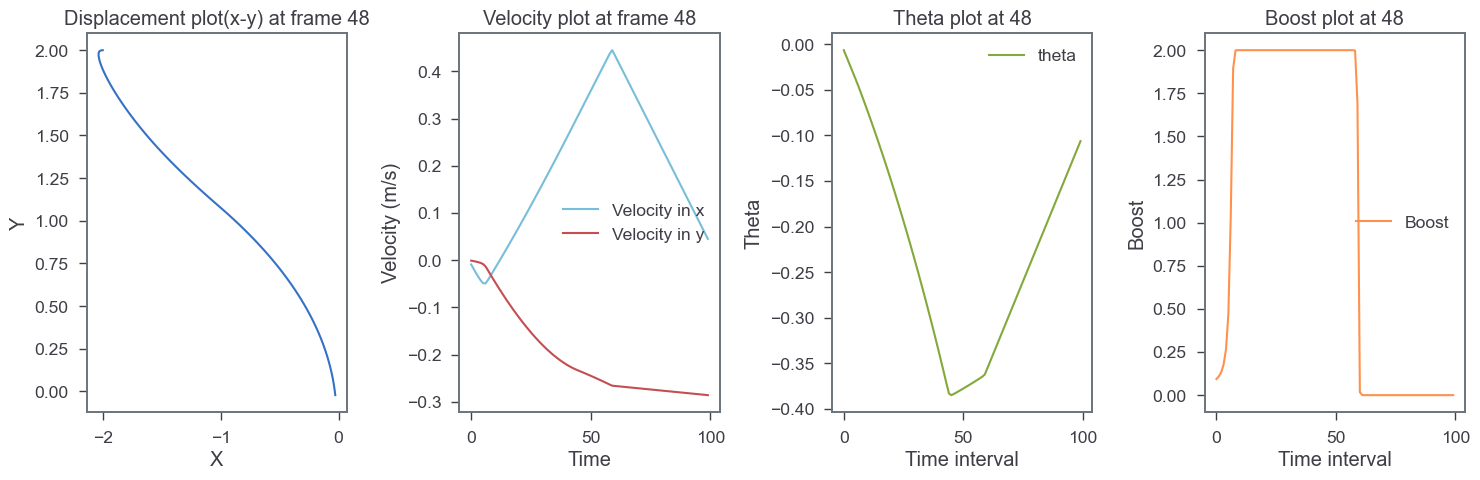

[50] loss: 0.019


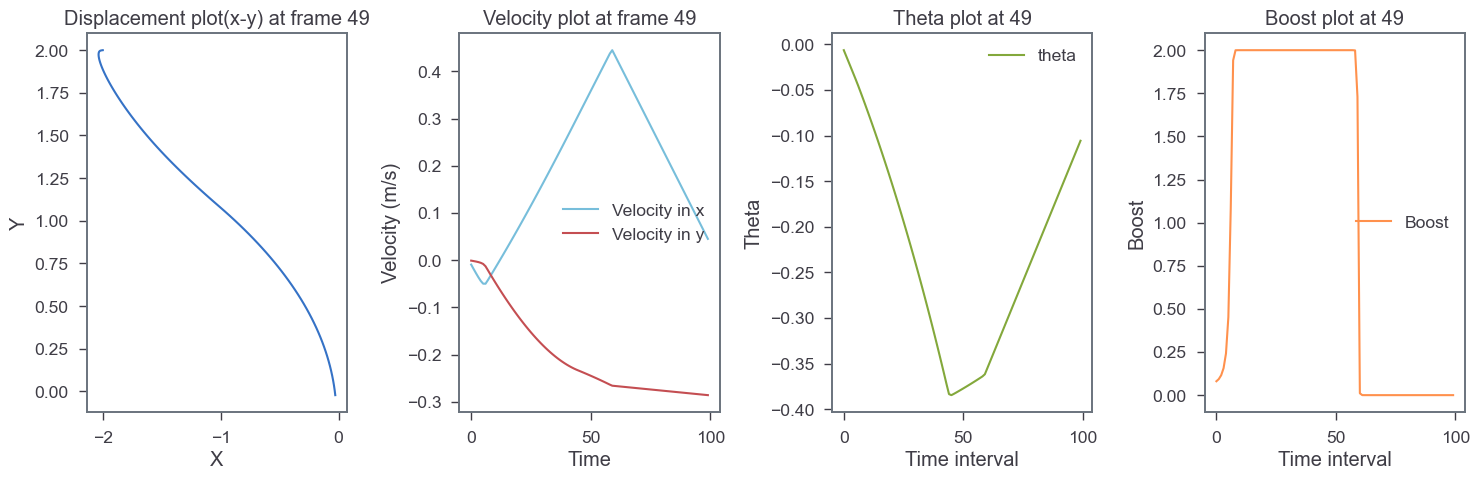

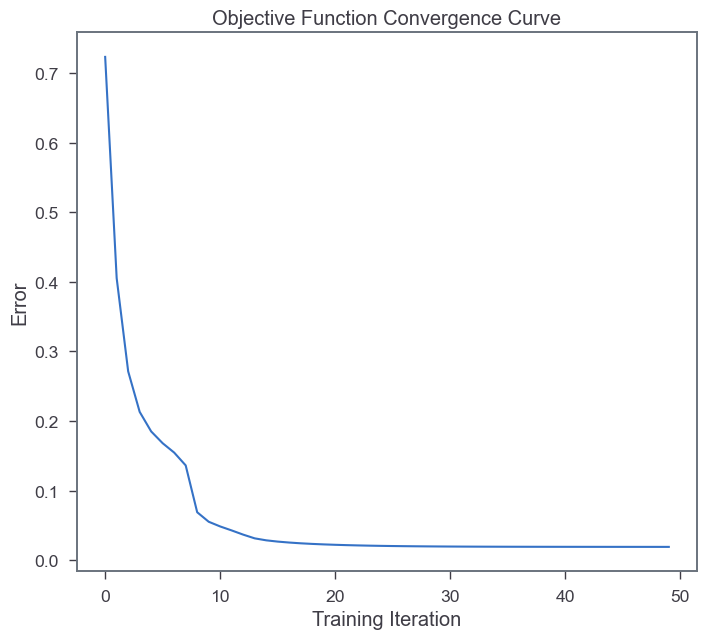

Generating Animation


IntProgress(value=0, max=101)

(100, 5) (100, 2)


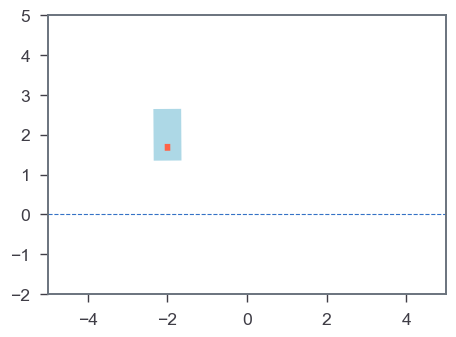

In [ ]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

#!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
#!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

# environment parameters
FRAME_TIME = 0.1  # time interval
BACKWARD_ACCEL_Y = 0.005  # backward constant in Y direction 
BACKWARD_ACCEL_X = 0.1  # backward constant in X direction
BOOST_ACCEL = 0.1  # boosting constant
delta = 60 # steering angle
L = 0.5  # wheelbase
OMEGA_RATE = math.tan(delta)/L  # max rotation rate 
#cos_value = math.cos(delta)
#Delta_OMEGA_RATE = (1 / L) * (1 / (cos_value ** 2))
# Oomega_rate = 3.4641

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Boost
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
        """
        
        delta_state_backward = torch.tensor([[0., 0.,-BACKWARD_ACCEL_X * FRAME_TIME, -BACKWARD_ACCEL_Y * FRAME_TIME, 0.]])

        state_tensor = torch.zeros((1, 5))              # 1 by 5 matrix with 0
        state_tensor[0, 3] = torch.cos(state[0, 4] + 90)    # cos(input)
        state_tensor[0, 2] = torch.sin(state[0, 4] + 90)    # sin(input)
        state_tensor[0, 4] = (state[0, 4]) * OMEGA_RATE     # theta(input)

        # 
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))       # multiple state_tensor & action & transpose

        # Theta
        delta_state_theta = BOOST_ACCEL * FRAME_TIME * OMEGA_RATE * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),action[0, 1].reshape(-1, 1))

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        
        shift_mat = torch.tensor([[0., 0.,FRAME_TIME, 0., 0.],
                                 [0., 0., 0., FRAME_TIME, 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.]])

        state = torch.matmul(step_mat, state.T) + torch.matmul(shift_mat, delta_state.T) * 0.5 + torch.matmul(shift_mat, delta_state_backward.T) * 0.5 
        state = state.T

        state = state + delta_state  + delta_state_backward + delta_state_theta

        return state
    
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action
        
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[-2.,2.,0.,0.,0]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    
    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        boost = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, boost, c = 'y', label = "Boost")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Boost")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Boost plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.3          # m
        width = 0.3          # m

        #
        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 20, color = 'lightblue') # Vehicle body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # Trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # Boost line

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            vehicle_theta = x_t[i, 4]

            vehicle_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            vehicle_x_points = [vehicle_x + length/1 * np.sin(vehicle_theta), vehicle_x - length/1 * np.sin(vehicle_theta)]

            vehicle_y = x_t[i, 1]
            vehicle_y_points = [vehicle_y + length/1 * np.cos(vehicle_theta), vehicle_y - length/1 * np.cos(vehicle_theta)]

            ln1.set_data(vehicle_x_points, vehicle_y_points)

            boost_mag = u_t[i, 0]
            boost_angle = -u_t[i, 1]

            flame_length = (boost_mag) * (0.4/v_exhaust)
            # flame_x_points = [vehicle_x_points[1], vehicle_x_points[1] + flame_length * np.sin(boost_angle - vehicle_theta)]
            # flame_y_points = [vehicle_y_points[1], vehicle_y_points[1] - flame_length * np.cos(boost_angle - vehicle_theta)]
            flame_x_points = [vehicle_x_points[1], vehicle_x_points[1] - flame_length * np.sin(vehicle_theta)]
            flame_y_points = [vehicle_y_points[1], vehicle_y_points[1] - flame_length * np.cos(vehicle_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("Automatic Parking.gif", writer=writer)

T = 100  # number of time steps of the simulation
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(50)  # training with number of epochs (gradient descent steps)

## Analysis of the results

At first, I create with this formula:
$$
\begin{aligned}
& x(t+1) = x(t) + \dot{x}(t) \Delta t + 0.5 a(t)\sin(\theta(t) + 90) \Delta t^2, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 a(t)\cos(\theta(t) + 90) \Delta t^2, \\
& \dot{x}(t+1) = \dot{x}(t) + a(t)\sin(\theta(t) + 90) \Delta t \\
& \dot{y}(t+1) = \dot{y}(t) + a(t)\cos(\theta(t) + 90) \Delta t \\
& \theta(t+1) = (\theta(t) + a(t) *\Delta t) * \omega(t) \\
& \omega(t) = \tan(\delta) / L
& \end{aligned}
$$
The problem is that after changing variables with this dynamic block, the vehicle's trajectory will be almost linear and stop at a point ($ \theta $ will be zero) after the vehicle doesn't boost.
<br>
So I multiply $ \theta(t) $ with a(t) and $ \Delta t $ to increase the angle of the rotation to make sure the trajectory will follow the imaginary path.
### Dynamics

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
      
        """
        
        delta_state_gravity = torch.tensor([[0., 0., BACKWARD_ACCEL_X * FRAME_TIME, -BACKWARD_ACCEL_Y * FRAME_TIME, 0.]])

        state_tensor = torch.zeros((1, 5))              # 1 by 5 matrix with 0
        state_tensor[0, 3] = torch.cos(state[0, 4] + 90)    # cos(input)
        state_tensor[0, 2] = torch.sin(state[0, 4] + 90)    # sin(input)
        state_tensor[0, 4] = torch.mul(state[0, 4], action[0, 1].reshape(-1, 1)) * OMEGA_RATE       

        # 
        delta_state = torch.zeros((1, 5))
        delta_state = delta_state + BOOST_ACCEL * FRAME_TIME * (torch.mul(state_tensor[0, 3], action[0, 0].reshape(-1, 1)) + torch.mul(state_tensor[0, 2], action[0, 0].reshape(-1, 1)))       # multiple state_tensor & action & transpose

        # Theta
        delta_state_theta = BOOST_ACCEL * FRAME_TIME * OMEGA_RATE * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),action[0, 1].reshape(-1, 1))

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        
        shift_mat = torch.tensor([[0., 0.,FRAME_TIME, 0., 0.],
                                 [0., 0., 0., FRAME_TIME, 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.]])

        state = torch.matmul(step_mat, state.T) + torch.matmul(shift_mat, delta_state.T) * 0.5 + torch.matmul(shift_mat, delta_state_gravity.T) * 0.5 
        state = state.T

        state = state + delta_state + delta_state_gravity + delta_state_theta

        return state

To build the formula from above, the ``state_tensor`` should be $ \dot{\theta} * Omega~Rate $, and I create a 1-by-5 matrix to ``delta_state``.
<br>
However, the result shows that the trajectory doesn't fit well with $ \dot{\theta} $ and ``delta_state``. 
<br>
Therefore, I changed it to $ \theta $ for a better trajectory.


### Optimization
The original learning rate is 0.01, which works well in this code. 
<br>
The boosting time will decrease rapidly with higher learning rate (e.g. lr = 0.2). On the contrary, the lower learning rate will increase the boosting time.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59115d46-a419-43f9-a3fe-b160aca2a335' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>